In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, PySimpleGUI as sg
import os, warnings, tabulate
from IPython.display import display, HTML, Markdown, clear_output
from collections import Counter

## Re-Import from pickles
The below will read in all .pkl files in the directory as dataframes with a name equal to 'df_' + the filename.

In [2]:
# Get a list of all files in the folder
all_files = os.listdir('Vision_Data/working_data/')
# Filter the list to include only CSV files
pkl_files = [file for file in all_files if file.endswith('.pkl')]
# make a list of full paths
file_path_list = ['Vision_Data/working_data/' + file for file in pkl_files]

# pretty sure this wasn't serving any purpose

# # Extract the filenames and full paths
# full_paths = [os.path.abspath(os.path.join('Vision/', file)) for file in pkl_files]
names = [name.strip('.pkl') for name in pkl_files]

# Pair names with file paths using zip
dflist = list(zip(names, file_path_list))

# Create dataframes from all with matching names
for name, df_path in dflist:
    exec(f"df_{name} = pd.read_pickle(df_path)")

In [3]:
# # single import for minor corrections
# df_CL = pd.read_pickle('Vision_Data/working_data/CL.pkl')
# df_PR = pd.read_pickle('Vision_Data/working_data/PR.pkl')
# df_LD = pd.read_pickle('Vision_Data/working_data/LD.pkl')

### Basic EDA

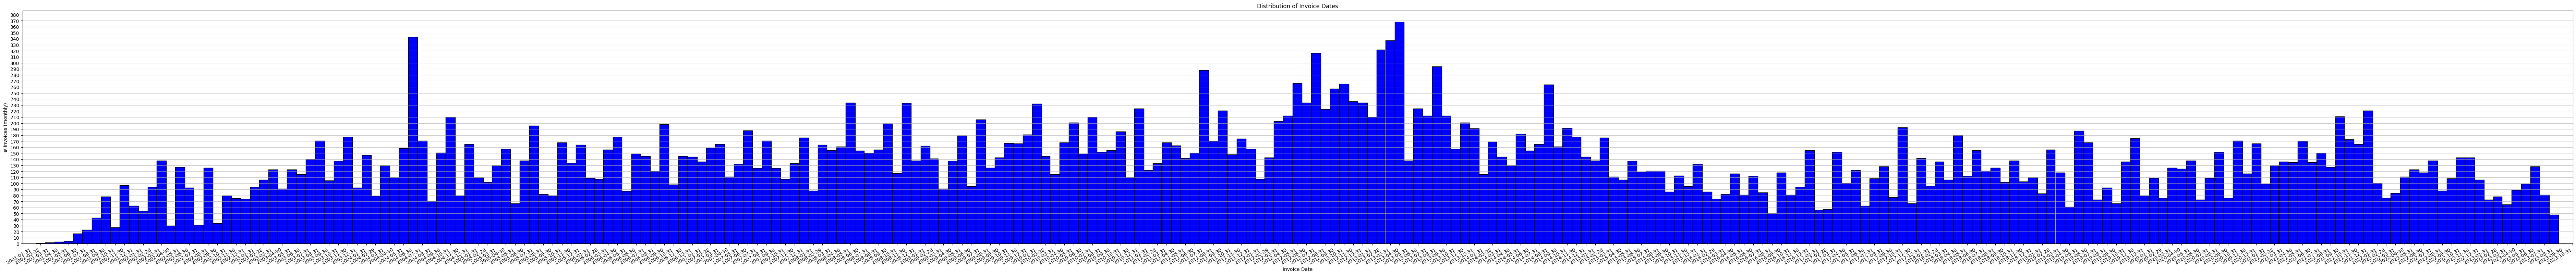

In [4]:
start_date = pd.to_datetime('2001-01-01')
end_date = pd.to_datetime('2023-11-01')
plot_range = df_AR['InvoiceDate'][(df_AR['InvoiceDate'] > start_date) & (df_AR['InvoiceDate'] < end_date)]
num_bins = pd.date_range(start=start_date, end=end_date, freq='M')

# Create a histogram
plt.figure(figsize=(96, 10))
plt.hist(plot_range , bins=num_bins, color='blue', edgecolor='black', align='right')

# Set labels and title
plt.xlabel('Invoice Date')
plt.ylabel('# Invoices (monthly)')
plt.title('Distribution of Invoice Dates')

# Set x-axis ticks to number of bins & y-ticks to steps of ten for the range of the data
plt.xticks(num_bins, rotation=45, ha='left')
plt.yticks(np.arange(0, 381, step=10))
# Format x-axis as dates
plt.gcf().autofmt_xdate()
# Set x-axis limits to desired range
plt.xlim(start_date, end_date)

# Add horizontal grid lines
plt.grid(axis='y', linestyle='-', alpha=0.7)

# Show the plot
plt.show()

#### Chart: All Invoices, by Date
- Potentially useful to establish periodicity
- Want to refine to income by month
- Want to compare to # proposals perhaps

Problems with the above: doesn't seem to be aligning bins correctly with dates, may not be binning by month as intended, xticks should be appearing at the end of each month bin, start and end are blank for some reason

## Create combined dataframe

In [5]:
df_CL = df_CL.drop(labels = ['ExportInd', 'WebSite', 'Memo', 'CurrentStatus',
                          'CreateUser', 'ModUser', 'ModDate', 'ClientInd', 'VendorInd',
                          'LinkedVendor', 'PriorWork', 'Competitor', 'EightA', 'Hubzone',
                          'Incumbent', 'AjeraSync'], axis=1)

In [6]:
df_CL.rename(columns={'Name': 'ClientName', 'CreateDate': 'ClientCreated'}, inplace=True)

In [7]:
# some duplicates exist.  I will need to combine these.
# df['ClientName'].value_counts() > 1

# Get the counts for each unique 'ClientName'
name_counts = df_CL['ClientName'].value_counts()

# Get a list of 'ClientName' values with counts greater than 1
CL_dupes_list = name_counts[name_counts > 1].index.tolist()
## naive version
# CL_dupes_list = []
# for i in range(0, len(name_counts)):
#     CL_entry_count = name_counts.iloc[i]
#     if CL_entry_count > 1:
#         CL_dupes_list.append(name_counts.index[i])


In [8]:
CL_dupes_list

['Associa',
 'Community Consolidated School District 59',
 'Streamwood Park District',
 'The American Institute of Architects',
 'Eurest Services',
 'PM Realty Group',
 'Jones Lang LaSalle Americas, Inc.',
 'Jones Lang LaSalle',
 'Indiana Department of Education',
 'National Pest Management Association']

In [9]:
# suppress annoying warning message spam
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
## Attempt at making it a function, not currently working as intended
# temp_CL_slice = pd.DataFrame()

# def standardize_client_id(searchterm, newname, others_rows=[]):
#     temp_CL_slice = df_CL[df_CL['ClientName'].str.contains(searchterm, na=False)]
#     if len(others_rows) > 0:
#         for row in others_rows:
#             temp_CL_slice = temp_CL_slice.append(df_CL.loc[row])
#     for client_id in temp_CL_slice['ClientID']:
#         df_PR['ClientID'][df_PR['ClientID'] == client_id] = newname

# standardize_client_id('Eurest', 'ESFM')

In [11]:
# some of these are obvious and can be combined

# Associa has a bunch
# df_CL[df_CL['ClientName'] == 'Associa']
# df_CL[((df_CL[['ClientID', 'Client', 'ClientName']] == 'Associa').any(axis=1))]
# 8E2567CD484B4B199E9E03F4DE458C0A, 03143F65E94F413085E9BABFCE832635,
# 4F5225D2AAC5488880BC5CF4FB23E6F9, & 5F4D3D4F460F48B48032779E8FBEDAA9
# note that the final one is Associa PMG of Houston
# rolling in the ones that are Associa by another name
# df_CL.iloc[4603] # "Managed by SCS (Associa)" (from Memo field)
# ^ 0D7956F7C65543B083E0AA096411B2A1
# df_CL.iloc[4620] # "An Associa Company"
# ^ 28894C8011F74A9A8548C79DD06B170B
# df_CL.iloc[5057] # aka "Specialized Community Services"
# ^ SCS
# df_CL.iloc[5058] # aka "Select Community Services"
# ^ SELECTCOMM
# df_CL.iloc[5060] # aka "Select Community Specialists"
# ^ SMALLCOMM

temp_CL_slice = df_CL[df_CL['ClientName'].str.contains('Associa', na=False)]

# would otherwise turn up a tone of "associations" etc, so I'm creating a mask of those to drop
mask = temp_CL_slice['ClientName'].str.contains('Associat')
# Drop the subset from the original dataframe
temp_CL_slice = temp_CL_slice.drop(temp_CL_slice[mask].index)
# I've checked, it leaves only the ones we want

temp_CL_slice = temp_CL_slice.append(df_CL.iloc[4603])
temp_CL_slice = temp_CL_slice.append(df_CL.iloc[4620])
temp_CL_slice = temp_CL_slice.append(df_CL.iloc[5057])
temp_CL_slice = temp_CL_slice.append(df_CL.iloc[5058])
temp_CL_slice = temp_CL_slice.append(df_CL.iloc[5060])

# fix them all in DF_PR
for client_id in temp_CL_slice['ClientID']:
    df_PR['ClientID'][df_PR['ClientID'] == client_id] = 'Associa / SCS'

# Fix the row to keep in df_CL
df_CL.loc[5057]['ClientID'] = 'Associa / SCS'

# drop the dupes
droplist = list(temp_CL_slice.index)
droplist.pop(6)
df_CL.drop(droplist, inplace=True)

In [12]:
#df_CL[df_CL['ClientName'] == CL_dupes_list[1]] # Community Consolidated School District 59
# F19F195C97F54DCA8A4312CD46B6B205 - 2311
# 8AD4AFAB88724F98A57E059C663EB889 - 2894

temp_CL_slice = df_CL[df_CL['ClientName'].str.contains('District 59', na=False)]

for client_id in temp_CL_slice['ClientID']:
    df_PR['ClientID'][df_PR['ClientID'] == client_id] = 'CCSD59'
    
# Fix the row to keep in df_CL
df_CL.loc[2894]['ClientID'] = 'CCSD59'

df_CL.drop(2311, inplace=True)

In [13]:
# df_CL[df_CL['ClientName'] == CL_dupes_list[2]] # Streamwood Park District
# 0DD594427EEA4E539B4D2BEFFBF9D925 - 1612
# DF5A2E8868AA48DF90CC96F479A7E0BE - 2209
temp_CL_slice = df_CL[df_CL['ClientName'].str.contains('Streamwood', na=False)]
for client_id in temp_CL_slice['ClientID']:
    df_PR['ClientID'][df_PR['ClientID'] == client_id] = 'SPD'
    
# Fix the row to keep in df_CL
df_CL.loc[2209]['ClientID'] = 'SPD'

df_CL.drop(1612, inplace=True)

In [14]:
# df_CL[df_CL['ClientName'] == CL_dupes_list[3]] # The American Institute of Architects
# 8CEECE492D9E4B0B9E2D8E7E192F1991 - 1341
# AIA - 5259
temp_CL_slice = df_CL[df_CL['ClientName'].str.contains('American Institute of Architects', na=False)]
for client_id in temp_CL_slice['ClientID']:
    df_PR['ClientID'][df_PR['ClientID'] == client_id] = 'AIA'
    
# Fix the row to keep in df_CL
df_CL.loc[5259]['ClientID'] = 'AIA'

df_CL.drop(1341, inplace=True)

In [15]:
# df_CL[df_CL['ClientName'] == CL_dupes_list[4]] # Eurest Services 
# aka Elevating Solutions in Facilities Management
# aka ESFM-USA
# 8775DB81F2E6476FAC41B8693C853566 - 356
# 1CC2A8BBE21142778F21F07D82E9C5E6 - 1242
# 092EB8FA554A464A84A144A8B00F4178 - 3433
temp_CL_slice = df_CL[df_CL['ClientName'].str.contains('Eurest', na=False)]
for client_id in temp_CL_slice['ClientID']:
    df_PR['ClientID'][df_PR['ClientID'] == client_id] = 'ESFM'
    
# Fix the row to keep in df_CL
df_CL.loc[3433]['ClientID'] = 'ESFM'

# drop the dupes
droplist = list(temp_CL_slice.index)
droplist.pop(2)
df_CL.drop(droplist, inplace=True)

In [16]:
df_CL[df_CL['ClientName'] == CL_dupes_list[5]] # PM Realty Group aka Madison-Marquette
# 7515359E3B1C426283E8B873D3AA7148 - 1027
# LZUMBRUNNEN1203624743312 - 1522
temp_CL_slice = df_CL[df_CL['ClientName'].str.contains('PM Realty', na=False)]
for client_id in temp_CL_slice['ClientID']:
    df_PR['ClientID'][df_PR['ClientID'] == client_id] = 'PMRG'
    
# Fix the row to keep in df_CL
df_CL.loc[1027]['ClientID'] = 'PMRG'

df_CL.drop(1522, inplace=True)

In [17]:
# df_CL[df_CL['ClientName'] == CL_dupes_list[6]] # Jones Lang LaSalle Americas, Inc
# JLL has TONS of aliases
temp_CL_slice = df_CL[df_CL['ClientName'].str.contains('Jones Lang', na=False)]
# 5A06445A2FF147B28B6EA3E13449CB1D - 743
# AFEB6071579844929B6CCEDDCC8C64B6 - 1061
# 017B3EADAA434EC3BC5B649E64F2138C - 1219
# 79170697EE0048939923316927FE4CBC - 1324
# 95256CE405ED4FED92919A6457B5FC73 - 1351
# F7F86AF6780A44A4A596F132C5B88ABB - 1467
# RERDMAN1284480299483 - 1561
# 47D4DEBFA4864DB681ED13A0EB6653F1 - 1764
# DC6407310CED4D13A6D38DA6D0D96B84 - 3462
# 48540B046CDE4BF8B4EC235086F8E06E - 3511
# 866C75A8F0F64886B23A8ECA49B16D35 - 3847
# 39C72CC1C09748E68ED5B1D2BB998BF6 - 4482
# 70C34CB00B0146FDA07A081CBF881727 - 4506
# C2217B8EB73D4A1198203DC1CC972A58 - 4537
# RGUTIERREZ1300806144819 - 4583
# JLL - 5003
# JONESLANG - 5005
# S - 6036

## catch other entries
# subset_df = df_CL[df_CL['ClientName'].str.contains('Jones', na=False)]
# # Exclude entries that are already in temp_df_slice
# result_df = subset_df[~subset_df['ClientName'].isin(temp_CL_slice['ClientName'])]
# result_df
temp_CL_slice = temp_CL_slice.append(df_CL.loc[2129]).sort_index()

# ## another catch
# subset_df = df_CL[df_CL['ClientName'].str.contains('Lang', na=False)]
# # # Exclude entries that are already in temp_df_slice
# result_df = subset_df[~subset_df['ClientName'].isin(temp_CL_slice['ClientName'])]
# # none here

# ## another
# subset_df = df_CL[df_CL['ClientName'].str.contains('LaSalle', na=False)]
# # # Exclude entries that are already in temp_df_slice
# result_df = subset_df[~subset_df['ClientName'].isin(temp_CL_slice['ClientName'])]
# LaSalle Investment Management is the same company.
temp_CL_slice = temp_CL_slice.append(df_CL.loc[5174]).sort_index()
## that should do it

for client_id in temp_CL_slice['ClientID']:
    df_PR['ClientID'][df_PR['ClientID'] == client_id] = 'JLL'
    
# Fix the row to keep in df_CL
df_CL.loc[5005]['ClientID'] = 'JLL'

# drop the dupes
droplist = list(temp_CL_slice.index)
droplist.pop(17)
df_CL.drop(droplist, inplace=True)

In [18]:
# JLL was also #7 in the list, so on to #8
df_CL[df_CL['ClientName'] == CL_dupes_list[8]] # Indiana Department of Education

# 282BAEA655C74E3393C9FABF425EC59E - 1257
# 1E5BBA0614F04405A7A5AABC5FE37C16 - 3715
temp_CL_slice = df_CL[df_CL['ClientName'].str.contains('Indiana Department of Ed', na=False)]
for client_id in temp_CL_slice['ClientID']:
    df_PR['ClientID'][df_PR['ClientID'] == client_id] = 'INDOE'
    
# Fix the row to keep in df_CL
df_CL.loc[3715]['ClientID'] = 'INDOE'

df_CL.drop(1257, inplace=True)

In [19]:
# df_CL[df_CL['ClientName'] == CL_dupes_list[9]] # National Pest Management Association
# 352C564148124BB596CCEF5CE603CB1F - 1000
# 29AC4C92DC8B479FB37AD5EB22736BFB - 3734
temp_CL_slice = df_CL[df_CL['ClientName'].str.contains('National Pest Management Association', na=False)]
for client_id in temp_CL_slice['ClientID']:
    df_PR['ClientID'][df_PR['ClientID'] == client_id] = 'NPMA'
    
# Fix the row to keep in df_CL
df_CL.loc[1000]['ClientID'] = 'NPMA'

df_CL.drop(3734, inplace=True)

In [20]:
## That does it for the dupe list, now to double-check
# name_counts = df_CL['ClientName'].value_counts()
# name_counts[name_counts > 1].index.tolist()
## Looks good

In [21]:
# Drop duplicates, keeping the first occurrence (which will be the earliest date)
# df_CL.drop_duplicates(subset=['ClientName'], keep='first', inplace=True)
## superceded by my drops above

# Sort the DataFrame by 'ClientName' and 'CreateDate'
df_CL = df_CL.sort_values(by=['ClientName', 'ClientCreated'])

# Reset the index of the DataFrame
df_CL.reset_index(drop=True, inplace=True)

In [22]:
# Double check.  This time, get the counts for each unique 'ClientID'
id_counts = df_CL['ClientID'].value_counts()

# Get a list of 'ClientName' values with counts greater than 1
CL_dupes_list = id_counts[id_counts > 1].index.tolist()
# CL_dupes_list # none found

In [23]:
len(df_PR['ClientID'].unique())

3983

In [24]:
vals_only_in_1 = []
def compare_columns(df1, column_name1, df2=None, column_name2=None):
    # Set defaults for df2 and column names
    if df2 is None:
        df2 = df1
    if column_name2 is None:
        column_name2 = column_name1

    # Get unique values from both dataframes and columns
    unique_vals_1 = df1[column_name1].unique()
    unique_vals_2 = df2[column_name2].unique()

    # Find the common unique values
    common_vals = set(unique_vals_1) & set(unique_vals_2)

    # Find unique values in df1 that are not in df2
    vals_only_in_1 = set(unique_vals_1) - common_vals

    # Find unique values in df2 that are not in df1
    vals_only_in_2 = set(unique_vals_2) - common_vals

    # Get the counts for each case
    common_count = len(common_vals)
    only_in_1_count = len(vals_only_in_1)
    only_in_2_count = len(vals_only_in_2)

    # Check for null values
    null_count_1 = df1[column_name1].isna().sum()
    null_count_2 = df2[column_name2].isna().sum()

    # Print the counts
    print(f'Number of common values between {column_name1} and {column_name2}: {common_count}')
    print(f'Number of {column_name1} values only in df1: {only_in_1_count}')
    print(f'Number of {column_name2} values only in df2: {only_in_2_count}')
    print(f'Number of null values in {column_name1} in df1: {null_count_1}')
    print(f'Number of null values in {column_name2} in df2: {null_count_2}')

    return common_count, common_vals

# Compare ClientID in df_PR and df_CL
clientID_count, common_client_ids = compare_columns(df_PR, 'ClientID', df_CL)

Number of common values between ClientID and ClientID: 3982
Number of ClientID values only in df1: 1
Number of ClientID values only in df2: 2117
Number of null values in ClientID in df1: 48
Number of null values in ClientID in df2: 0


The 1 ClientID unique to PR is just "nan"

In [25]:
def nullsums(df, check_cols):
    print("Nulls in:\n")
    for col in check_cols:
        null_sum = df[col].isna().sum()
        print(f'{col}: {null_sum}\n')

In [26]:
## null sums of features of interest in CL
check_cols = ['GovernmentAgency', 'WomanOwned', 'AlaskaNative',
              'VetOwnedSmallBusiness', 'DisabledVetOwnedSmallBusiness', 
              'MinorityBusiness', 'DisadvBusiness']
## removed because they're either 100% null or close to:
#  'Specialty', 
## possibly reconstructable:
# 'SpecialtyType', #(only 200 but maybe can be used to attribute others)
nullsums(df_CL, check_cols)

Nulls in:

GovernmentAgency: 1

WomanOwned: 1

AlaskaNative: 1

VetOwnedSmallBusiness: 1

DisabledVetOwnedSmallBusiness: 1

MinorityBusiness: 1

DisadvBusiness: 1



In [27]:
# df_CL['GovernmentAgency'].value_counts()
# all but one have the same value, N

# df_CL[df_CL['ClientName'].str.contains('National', na=False)]

# with pd.option_context('display.max_rows', 250, 'display.max_columns', 20):
#     # use with+display to temporarily change the max_rows
#     display(df_CL[df_CL['ClientName'].str.contains('Service', na=False)])
df_CL.iloc[5600]
# clearly the field doesn't properly represent which are govt and which aren't

ClientID                         1EC300D2514540AAA1414C3024A59D37
Client                                                        NaN
ClientName                          US National Whitewater Center
Status                                                          A
ClientCreated                                 2015-11-12 20:32:25
Recommend                                                       N
DisadvBusiness                                                  N
DisabledVetOwnedSmallBusiness                                   N
HBCU                                                            N
MinorityBusiness                                                N
SmallBusiness                                                   N
VetOwnedSmallBusiness                                           N
WomanOwned                                                      N
AlaskaNative                                                    N
SpecialtyType                                                 NaN
Employees 

In [28]:
# the one row without it doesn't look like a government agency either
df_CL[df_CL['GovernmentAgency'] != "N"]

,ClientID,Client,ClientName,Status,ClientCreated,Recommend,DisadvBusiness,DisabledVetOwnedSmallBusiness,HBCU,MinorityBusiness,SmallBusiness,VetOwnedSmallBusiness,WomanOwned,AlaskaNative,SpecialtyType,Employees,AnnualRevenue,GovernmentAgency
1013,65DCCB20591940B6898C064168E250D6,NaN,"Cathedral Avenue Cooperative, Inc.",A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_CL['WomanOwned'].value_counts()
# this appears to be valid

N    6077
Y      21
Name: WomanOwned, dtype: int64

In [30]:
# df_CL['AlaskaNative'].value_counts()
# only one not marked N
df_CL[df_CL['AlaskaNative'] != "N"]
# is this actually Alaska Native owned?

,ClientID,Client,ClientName,Status,ClientCreated,Recommend,DisadvBusiness,DisabledVetOwnedSmallBusiness,HBCU,MinorityBusiness,SmallBusiness,VetOwnedSmallBusiness,WomanOwned,AlaskaNative,SpecialtyType,Employees,AnnualRevenue,GovernmentAgency
1013,65DCCB20591940B6898C064168E250D6,NaN,"Cathedral Avenue Cooperative, Inc.",A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# df_CL['VetOwnedSmallBusiness'].value_counts()

# df_CL[df_CL['VetOwnedSmallBusiness'] == "Y"]
# are these 6 actually vetowned small?

df_CL[df_CL['VetOwnedSmallBusiness'].isna() == True]
# and is the null one vet owned or not?
df_CL[df_CL['ClientName'].str.contains('Cathedral Ave', na=False)]
# Likely not, it looks like Cathedral Coop is just nulls for most columns

,ClientID,Client,ClientName,Status,ClientCreated,Recommend,DisadvBusiness,DisabledVetOwnedSmallBusiness,HBCU,MinorityBusiness,SmallBusiness,VetOwnedSmallBusiness,WomanOwned,AlaskaNative,SpecialtyType,Employees,AnnualRevenue,GovernmentAgency
1013,65DCCB20591940B6898C064168E250D6,NaN,"Cathedral Avenue Cooperative, Inc.",A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# what's in projects for Cathedral Ave Coop anyway?
with pd.option_context('display.max_rows', 20, 'display.max_columns', 200):
    # use with+display to temporarily change the max_rows
    display(df_PR[df_PR['ClientID'] == '65DCCB20591940B6898C064168E250D6'])

,WBS1,WBS2,WBS3,Name,ChargeType,SubLevel,Principal,ProjMgr,Supervisor,ClientID,CLAddress,StartDate,EndDate,BillByDefault,BillWBS1,BillWBS2,BillWBS3,ContactID,CLBillingAddr,LongName,Address1,Address2,Address3,City,State,Zip,County,Country,FederalInd,ProjectType,Responsibility,Referable,EstCompletionDate,ActCompletionDate,ContractDate,BidDate,FirmCost,TotalProjectCost,ClientAlias,BillingClientID,BillingContactID
15339,P01.2021.009834,NaN,NaN,Cathedral Avenue Cooperative Reserve Stu,P,Y,88,274.0,274.0,65DCCB20591940B6898C064168E250D6,<Default>,2022-01-10,NaN,C,NaN,NaN,NaN,FMSCLTheBoston967,NaN,Cathedral Avenue Cooperative Reserve Study 2021,NaN,NaN,NaN,Washington,DC,NaN,NaN,US,N,46.0,P,N,2022-05-27 00:00:00,NaT,NaT,NaT,0.0,0.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967
19242,P01.2021.009834,PROP,PROP,Proposal,P,N,88,274.0,274.0,65DCCB20591940B6898C064168E250D6,<Default>,2022-01-10,NaN,C,NaN,NaN,NaN,FMSCLTheBoston967,NaN,Proposal,NaN,NaN,NaN,Washington,DC,NaN,NaN,US,N,46.0,P,N,2022-05-27 00:00:00,NaT,NaT,NaT,0.0,0.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967
23360,P01.2021.009834,PROP,NaN,Proposal,P,Y,88,274.0,274.0,65DCCB20591940B6898C064168E250D6,<Default>,2022-01-10,NaN,C,NaN,NaN,NaN,FMSCLTheBoston967,NaN,Proposal,NaN,NaN,NaN,Washington,DC,NaN,NaN,US,N,46.0,P,N,2022-05-27 00:00:00,NaT,NaT,NaT,0.0,0.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967
25708,P01.2013.007676,PROP,NaN,Proposal,P,Y,58,58.0,58.0,65DCCB20591940B6898C064168E250D6,<Default>,2013-06-03,NaN,C,NaN,NaN,NaN,FMSCLTheBoston967,<Default>,Proposal,NaN,NaN,NaN,Washington,DC,20016,NaN,US,N,46.0,P,N,2013-07-26 00:00:00,NaT,NaT,NaT,0.0,0.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967
25709,P01.2013.007676,PROP,PROP,Proposal,P,N,58,58.0,58.0,65DCCB20591940B6898C064168E250D6,<Default>,2013-06-03,NaN,C,NaN,NaN,NaN,FMSCLTheBoston967,<Default>,Proposal,NaN,NaN,NaN,Washington,DC,20016,NaN,US,N,46.0,P,N,2013-07-26 00:00:00,NaT,NaT,NaT,0.0,0.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967
50089,P01.2013.007676,NaN,NaN,Cathedral Avenue Cooperative Reserve Stu,P,Y,58,58.0,58.0,65DCCB20591940B6898C064168E250D6,<Default>,2013-08-26,NaN,C,NaN,NaN,NaN,FMSCLTheBoston967,<Default>,Cathedral Avenue Cooperative Reserve Study,NaN,NaN,NaN,Washington,DC,20016,NaN,US,N,46.0,P,N,2013-10-18 00:00:00,NaT,2013-08-23,NaT,11500.0,11500.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967
50329,R01.2013.007676,NaN,NaN,Cathedral Avenue Cooperative Reserve Stu,R,Y,58,58.0,58.0,65DCCB20591940B6898C064168E250D6,<Default>,2013-08-26,NaN,C,NaN,NaN,NaN,FMSCLTheBoston967,<Default>,Cathedral Avenue Cooperative Reserve Study,NaN,NaN,NaN,Washington,DC,20016,NaN,US,N,46.0,P,N,2013-10-18 00:00:00,NaT,2013-08-23,NaT,11500.0,11500.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967
50330,R01.2013.007676,1,NaN,Condition Assessment & Reserve Study,R,Y,58,58.0,58.0,65DCCB20591940B6898C064168E250D6,<Default>,2013-08-26,NaN,C,NaN,NaN,NaN,FMSCLTheBoston967,<Default>,Condition Assessment & Reserve Study,NaN,NaN,NaN,Washington,DC,20016,NaN,US,N,46.0,P,N,2013-10-18 00:00:00,NaT,2013-08-23,NaT,11500.0,11500.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967
50331,R01.2013.007676,1,1,Condition Assessment & Reserve Study,R,N,58,58.0,58.0,65DCCB20591940B6898C064168E250D6,<Default>,2013-08-26,NaN,C,R01.2013.007676,1,NaN,FMSCLTheBoston967,<Default>,Condition Assessment & Reserve Study,NaN,NaN,NaN,Washington,DC,20016,NaN,US,N,46.0,P,N,2013-10-18 00:00:00,NaT,2013-08-23,NaT,11500.0,11500.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967
65046,P01.2018.009369,NaN,NaN,Cathedral Avenue Cooperative RS Update,P,Y,88,111.0,111.0,65DCCB20591940B6898C064168E250D6,<Default>,2018-11-05,NaN,C,NaN,NaN,NaN,FMSCLTheBoston967,NaN,Cathedral Avenue Cooperative Reserve Study Update,4101 Cathedral Avenue NW,NaN,NaN,Washington,DC,20016,NaN,US,N,46.0,P,N,2019-01-07 00:00:00,NaT,NaT,NaT,0.0,0.0,NaN,65DCCB20591940B6898C064168E250D6,FMSCLTheBoston967


In [33]:
check_cols = ['FederalInd', 'ProjectType', 'Principal', 'Supervisor',
              'ProjMgr', 'ContactID', 'ClientAlias']

## removed because they're either 100% null or close to:
#  'ContractTypeGovCon', 'Solicitation', 
## possibly reconstructable:

nullsums(df_PR, check_cols)

Nulls in:

FederalInd: 3

ProjectType: 22116

Principal: 2960

Supervisor: 21621

ProjMgr: 4029

ContactID: 12695

ClientAlias: 80237



In [34]:
check_cols = ['ContactID', 'ClientID', 'Probability']

## removed because they're either 100% null or close to:
# 'MarketingCoordinator', 'ProposalManager', 'BusinessDeveloperLead', 
## possibly reconstructable:
#  'Source' -- about 55% null and no idea what the values mean but they are there

nullsums(df_Opportunity, check_cols)

Nulls in:

ContactID: 1130

ClientID: 377

Probability: 6



Some cleaning/processing to trim down the larger ones before exploring them.

In [35]:
# aggressively pair down CL and PR

In [36]:
df_CL.columns

Index(['ClientID', 'Client', 'ClientName', 'Status', 'ClientCreated',
       'Recommend', 'DisadvBusiness', 'DisabledVetOwnedSmallBusiness', 'HBCU',
       'MinorityBusiness', 'SmallBusiness', 'VetOwnedSmallBusiness',
       'WomanOwned', 'AlaskaNative', 'SpecialtyType', 'Employees',
       'AnnualRevenue', 'GovernmentAgency'],
      dtype='object')

In [37]:
# pare to just these
df_CL = df_CL[['ClientID', 'ClientName', 'SpecialtyType', 'Recommend', 'ClientCreated']]

In [38]:
df_PR.columns

Index(['WBS1', 'WBS2', 'WBS3', 'Name', 'ChargeType', 'SubLevel', 'Principal',
       'ProjMgr', 'Supervisor', 'ClientID', 'CLAddress', 'StartDate',
       'EndDate', 'BillByDefault', 'BillWBS1', 'BillWBS2', 'BillWBS3',
       'ContactID', 'CLBillingAddr', 'LongName', 'Address1', 'Address2',
       'Address3', 'City', 'State', 'Zip', 'County', 'Country', 'FederalInd',
       'ProjectType', 'Responsibility', 'Referable', 'EstCompletionDate',
       'ActCompletionDate', 'ContractDate', 'BidDate', 'FirmCost',
       'TotalProjectCost', 'ClientAlias', 'BillingClientID',
       'BillingContactID'],
      dtype='object')

In [39]:
# there's more in PR that seems likely to be relevant, but we can still drop most columns
df_PR = df_PR[['WBS1', 'WBS2', 'WBS3', 'Name', 'StartDate', 'ClientID',
               'LongName', 'EndDate', 'ContractDate', 'TotalProjectCost']]

In [40]:
# still a lot of nulls, but there are likely reasons.  We'll look at that soon.
with pd.option_context('display.max_rows', 200, 'display.max_columns', 10):
    # use with+display to temporarily change the max_rows
    display(df_PR.isna().sum())

WBS1                    0
WBS2                15623
WBS3                38774
Name                  929
StartDate            9378
ClientID               48
LongName             3394
EndDate             79366
ContractDate        34840
TotalProjectCost        3
dtype: int64

In [41]:
# the Phases are mostly identified by number, but "PROP" is pretty clear.
df_PR['WBS2'].value_counts()

PROP       21094
1          14102
2           5489
3           3021
4           2032
           ...  
TWL            2
PROP-CE        2
TAM            2
FO11           2
FO1            1
Name: WBS2, Length: 536, dtype: int64

In [42]:
# similar with Task, though what on earth is ZZZ?  We can clarify these from other fields.
df_PR['WBS3'].value_counts()

PROP       9281
1          7484
ZZZ        2542
2          2459
PROPOSA    1602
           ... 
ITEM6         1
ITEM5         1
ITEM4         1
LAW 11        1
ELEV-CA       1
Name: WBS3, Length: 1945, dtype: int64

In [43]:
# using the list we generated with the column compare function above, establish a list 
# of clientIDs that exist in both tables
clientID_list = list(common_client_ids)

In [44]:
## probably no longer necessary
# df_PR['PhaseTask'] = df_PR['WBS2'].astype(str) + '-' + df_PR['WBS3'].astype(str)

In [45]:
# let's select a large client for test cases
df_PR['ClientID'].value_counts()

FEA                                 8869
C89DCC56D3B043ED926B07B57CE7C924    2547
JLL                                 2535
NPS                                 1526
GENERALSRV                           781
                                    ... 
MKUTZLER1231777182519                  1
TLARSON1242414408798                   1
KOBRIEN1169597203415                   1
A3EFCCB2D6C445B3BE77FA7FE58BE582       1
45F889ADC5FF42BBAB8031FDC0E5A219       1
Name: ClientID, Length: 3982, dtype: int64

In [46]:
df_PR.head()

,WBS1,WBS2,WBS3,Name,StartDate,ClientID,LongName,EndDate,ContractDate,TotalProjectCost
0,P01.1997.00983T,PROP,PROPOSA,Proposal,2002-11-04,PWCPS,Proposal,NaN,2002-11-01,0.0
1,P01.1998.001303,PROP,NaN,Semi-Annual Roof Assessments Proposal,2000-09-29,CFM MGMT,Semi-Annual Roof Assessments Proposal,NaN,2000-09-29,0.0
2,P01.1998.001303,PROP,PROPOSA,Proposal,2002-02-09,CFM MGMT,Proposal,NaN,2000-09-29,0.0
3,P01.1998.001504,PROP,NaN,Bethesda Park Condominium,2001-10-15,BETHESDAPK,Bethesda Park Condominium,NaN,2001-10-15,0.0
4,P01.1998.001504,PROP,PROPOSA,Proposal,2001-10-15,BETHESDAPK,Proposal,NaN,2001-10-15,0.0


In [47]:
df_PR.columns

Index(['WBS1', 'WBS2', 'WBS3', 'Name', 'StartDate', 'ClientID', 'LongName',
       'EndDate', 'ContractDate', 'TotalProjectCost'],
      dtype='object')

In [48]:
# what's with the entries with no client ID?
# probably just an attribution fail.  
df_PR[df_PR['ClientID'].isna()].head()

,WBS1,WBS2,WBS3,Name,StartDate,ClientID,LongName,EndDate,ContractDate,TotalProjectCost
1356,P01.2003.003674,PROP,NaN,NaN,2003-08-18,NaN,NaN,NaN,2003-08-18,0.0
1357,P01.2003.003674,PROP,PROPOSA,Proposal,2003-08-18,NaN,Proposal,NaN,2003-08-18,0.0
2358,P01.2005.004635,PROP,NaN,Proposal,2005-11-01,NaN,Proposal,NaN,2005-11-01,0.0
2359,P01.2005.004635,PROP,PROP,Proposal,NaT,NaN,Proposal,NaN,2005-11-01,0.0
3454,P05.2004.000072,PROP,NaN,NaN,2004-08-09,NaN,NaN,NaN,2004-08-09,0.0


In [49]:
# it appears some clientIDs are null
# we'll have to handle those somehow.  Maybe I can attribute them later, 
# but for now I'm just going to call them "unknown"

# first force it to identify them all as strings (there seem to be some numeric
# values being interpreted as integers))
df_PR['ClientID'] = df_PR['ClientID'].astype(str)
df_PR['ClientID'].fillna("UNKNOWN")

0                                   PWCPS
1                                CFM MGMT
2                                CFM MGMT
3                              BETHESDAPK
4                              BETHESDAPK
                       ...               
80663                MTOOMEY1222262872765
80664                           FIBERTECH
80665               BHIGGINS1223902053769
80666    BBCBB586A7A3400E91D7BA1FF4841945
80667                                 FEA
Name: ClientID, Length: 80665, dtype: object

In [50]:
## export the null client ids to share
# null_client_ids = df_PR[df_PR['ClientID'].isna()]
# null_client_ids.to_excel('null-client-ids-table-PR.xlsx')

In [51]:
## Name and LongName are basically the same. LongName has some nulls, and Name is
# sometimes truncated, so I'll take the best of both by combining.

# only rows where Longname contains Name (69593 rows)
# df_PR[df_PR['Name'].isin(df_PR['LongName'])]

# only rows where they match exactly (65706 rows)
# df_PR[df_PR['Name'] == df_PR['LongName']]

# use ~ tilde to negate mask, to return only rows where LongName doesn't contain Name (11072 rows)
name_mismatch = df_PR[~df_PR['Name'].isin(df_PR['LongName'])]

In [52]:
# It's only 48 rows, so not really worth worrying over.
df_PR[df_PR['ClientID'].isna()].shape

(0, 10)

In [53]:
# take out the LongName nulls.
name_mismatch = name_mismatch[name_mismatch['LongName'].notnull()]

In [54]:
# override names with longnames where they don't match
name_mismatch['Name'] = name_mismatch['LongName']

In [55]:
# update the original df with the names
df_PR.update(name_mismatch)

In [56]:
# drop the original Name column and keep the updated LongNames
df_PR.drop('Name', axis=1, inplace=True)
df_PR.rename(columns={"LongName": "Name"}, inplace=True)

### Combining
Add 'Phase' one slice at a time to df_PR

In [57]:
# so I need to put these together in a sequence as a function, take a slice of 
# the dataframe, a slice of that, a slice of that, and so on down, applying 
# transformations and dropping the name columns once their data is integrated,
# using nested loops.

# Theoretically I could do this all with one for loop, but reducing it to 
# small slices improves efficiency dramatically.  This way it finishes the
# full loop in a minute or two instead of 45m - several hours.

In [58]:
## first need to match longnames with project, phase, and task correctly.

# make a df of only the top level WBS1 codes (where WBS2 is null) to get project names
temp_df = df_PR[df_PR['WBS2'].isna()]

# assign ProjectName as a new column
temp_df = temp_df.assign(ProjectName = temp_df['Name'])

# drop other columns since we only need the map of WBS1 to ProjectName
temp_df = temp_df[['WBS1', 'ProjectName']]

# (version keeping WBS2 and ClientID just in case)
# temp_df = temp_df[['WBS1', 'WBS2'. 'ProjectName', 'ClientID']]

In [59]:
# map ProjectNames to df_PR based on WBS1 code
df_PR['ProjectName'] = df_PR['WBS1'].map(temp_df.set_index('WBS1')['ProjectName'])

In [60]:
# can now drop the top-level WBS1 rows from df_PR
df_PR = df_PR[df_PR['WBS2'].notna()]

#### Project Names assigned
At this point, df_PR has the correct ProjectNames for all entries.

Next, slice based on each project, assign Phase names to a new temp_df then re-merge and drop

In [61]:
# first I'll add the PhaseName column blank so it can be updated as we go
df_PR['PhaseName'] = None

In [62]:
# df_PR[df_PR['WBS3'].notnull()]
# 41891 rows expected when WBS3 nulls are dropped

In [63]:
# temp version with shortened client list
# client_list = client_list[0:10]

In [64]:
# # this takes some time to run so I'm commenting it out until it is needed again

# ## Loop through entire client list
# client_list = df_PR['ClientID'].unique()

# # for each client:
# for client in client_list:
#     # make a temporary df for just that client's section of the projects table
#     temp_df = df_PR[df_PR['ClientID'] == client]
    
#     # get the list of unique project codes associated with that client
#     project_list = temp_df['WBS1'].unique()
    
#     # for each project belonging to that client
#     for project in project_list:
#         # take that project as slice of temp_df
#         temp_df_project = temp_df[temp_df['WBS1'] == project]
#         # get all top level WBS2 / Phase names as a slice (blank WBS3 = top level of Phase)
#         project_phases = temp_df_project.dropna(subset='WBS3')
#         # create a phasename column within this slice
#         project_phases['PhaseName'] = None
        
#         # the 'Name' on those rows == the Phase name, so assign it within the df slice
#         for phase in list(project_phases['WBS2']):
#             project_phases['PhaseName'][project_phases['WBS2'] == phase] = project_phases['Name'][project_phases['WBS2'] == phase].values[0]
#             ## testing below, save a particular row to check
#             #phase_row = project_phases[project_phases['WBS2'] == phase]
#             #phase_row['PhaseName'] = project_phases['Name'][project_phases['WBS2'] == phase].values[0]
        
#         # drop all the rest
#         temp_df_phase = project_phases[['WBS2', 'PhaseName']]
        
#         # use update to only affect the chosen rows
#         temp_df_project.update(temp_df_phase[['PhaseName']])
#         # drop the nulls now that we've used them for what we needed
#         temp_df_project = temp_df_project[temp_df_project['WBS3'].notnull()]
#         # At this point we're ready to merge back into temp_df
#         temp_df.update(temp_df_project[['PhaseName']])
        
#     # When the project loop finishes, all we need to do is join the client's temp_df
#     # back df_PR, then we can repeat with the next client.
#     # merge (update) with main df_PR dataframe
#     df_PR.update(temp_df[['PhaseName']])
#     # now df_PR has the PhaseNames for that client's projects.
#     # code repeats for each client until df_PR is fully updated

In [65]:
## revisiting the nullsums
## null sums of features of interest in PR
check_cols = list(df_PR.columns)
## removed because they're either 100% null or close to:
#  
## possibly reconstructable:
# 
nullsums(df_PR, check_cols)

## note that this is the version without the WBS3 nulls dropped

## alternative to check_cols
# nullsums(df_PR, list(df_PR.columns))

Nulls in:

WBS1: 0

WBS2: 0

WBS3: 23151

StartDate: 9153

ClientID: 0

Name: 3391

EndDate: 63743

ContractDate: 27563

TotalProjectCost: 1

ProjectName: 4

PhaseName: 65042



In [66]:
# df_PR[df_PR['EndDate'].notnull()]
# with only two rows containing this value, it's probably meaningless.
df_PR.drop('EndDate', axis=1, inplace=True)

In [67]:
# checkpoint, dropping the WBS3 nulls
# df_PR[df_PR['PhaseName'].notnull()].to_pickle('Vision_Data/working_data/PR_prepared.pkl')

In [68]:
## I'll switch over to the processed copy now
df_PR = pd.read_pickle('Vision_Data/working_data/PR_prepared.pkl')

In [69]:
df_PR.head()

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName
0,P01.1997.00983T,PROP,PROPOSA,2002-11-04,PWCPS,Proposal,2002-11-01,0.0,Springwoods Elementary School,Proposal
2,P01.1998.001303,PROP,PROPOSA,2002-02-09,CFM MGMT,Proposal,2000-09-29,0.0,4816 - 4826 Chevy Chase Drive,Proposal
4,P01.1998.001504,PROP,PROPOSA,2001-10-15,BETHESDAPK,Proposal,2001-10-15,0.0,Bethesda Park Condominium,Proposal
6,P01.1999.001692,PROP,CONS/RE,2003-04-21,EARTHTECH,Consultation & Report,2003-04-21,0.0,Route 28/ Wellington Rd/ NS Railroad,Consultation & Report
7,P01.1999.001874,PROP,PROPOSA,2002-03-27,MCKISSACK,Proposal,2002-03-27,0.0,McKissack DC OPM Support,Proposal


In [70]:
client_list = df_PR['ClientID'].unique()
client_list

array(['PWCPS', 'CFM MGMT', 'BETHESDAPK', ...,
       '301E228E554D4A6F9CCF8B98F18FEC50', 'MTOOMEY1240316643500',
       'MTOOMEY1249992232765'], dtype=object)

In [71]:
### time to add other info to the table
## start from PR and merge CL in
# add blank cols
df_PR['ClientName'] = None
df_PR['SpecialtyType'] = None
df_PR['Recommend'] = None
CL_error_list = []
# update from df_CL
for client in client_list:
    try:
        df_PR['ClientName'][df_PR['ClientID'] == client] = df_CL['ClientName'][df_CL['ClientID'] == client].iloc[0]
    except:
        CL_error_list.append(client)
CL_error_list

['nan', '3095', '404', '3613', '510', '1860', '693', '3370', '4188']

In [72]:
# need this to read longer strings, which some of the names are
pd.set_option('display.max_colwidth', 255)

In [73]:
## GUI version of cleaning function (draft)
## commented out for now

# def main():
#     output_default = "Please enter a keyword, or type 'quit' to exit"
    
#     # Define the layout
#     layout = [
#         [sg.InputText(key='-INPUT-', size=(30, 1)), sg.Button('Submit')],
#         [sg.Output(size=(60, 10), key='-OUTPUT-', text_color='black')],
#     ]

#     # Create the window
#     window = sg.Window('Simple PySimpleGUI Example', layout, finalize=True)

#     # Print the default output
#     print_output(window, output_default)

#     # Event loop
#     while True:
#         event, values = window.read()

#         if event == sg.WINDOW_CLOSED:
#             break

#         if event == 'Submit':
#             user_input = values['-INPUT-']

#             # Check if the user wants to quit
#             if user_input.lower() == 'quit':
#                 break

#             # Update and display the output
#             print_output(window, user_input)

#         elif event == '\r' and window.FindElementWithFocus() == '-INPUT-':
#             # Check for Enter key pressed in the input field
#             user_input = values['-INPUT-']

#             # Check if the user wants to quit
#             if user_input.lower() == 'quit':
#                 break

#             # Update and display the output
#             print_output(window, user_input)

#     window.close()

# def print_output(window, output_text):
#     # Update the output pane with the provided text
#     window['-OUTPUT-'].update(value=output_text + '\n')

# if __name__ == '__main__':
#     main()

In [74]:
## attempting to write my function here
def standardize_duplicate_clients(client_id):
    print(df_PR[df_PR['ClientID'] == client_id])
    
standardize_duplicate_clients('4188')
# df_PR[df_PR['ClientID'] == '4188'] # GSA National something
# df_PR.loc[17047] # 'General Services Administration National Amenities Program Assessments'
# df_PR[df_PR['ProjectName'].str.contains('Amenities', na=False)]
# C01F4473763949458EE309EC240BA734
# df_PR[df_PR['ProjectName'].str.contains('GSA', na=False)]
# LTIFFANY1224273429400 -- 'GSA Rocky Mountain Region Port of Entry Energy...'
# 753E7AA9989B41B0ADA18B53DC561426 -- 'GSA Shave Energy Program Contract Support'
# 0B00783CAC5F482BBCDAE14C4F6116EB -- 'GSA Sustainable Facilities Tool - 2017'
# DWATKINS1256912883595 -- 'GSA Roof Consulting 12th & C Streets'
# CBRE -- '100 S. Charles Street Energy Audit (GSA Lease)'
# DGELDERMANN1200608095621 -- 'GSA MTFA BER SSA Child Care Center FCA Support'
# 8328A46F1AC0427EBBCAE4696BB38A7E -- 'GSA PBS R9 UTILITIES PROGRAM IDIQ FOR CONSULTING AND AUDITING - American Energy Solutions'
# LGILMER1302132364572 -- 'GSA Frank Hagel Federal Building West Plaza Replacement'
# DEA6987CBA8346C2A1017B6701CF6135 -- 'GSA IDIQ Supplemental Architect&Engineer Services States of Arizona, California (San Diego & Imperial Counties Only), Hawaii & Nevada'

## above are project names but also look at ClientName

## Most likely roll in with other GSA but ask some questions first


# df_PR[df_PR['ProjectName'].str.contains('', na=False)]
# df_PR['ClientName'][df_PR['ClientID'] == '3613'] = 
# df_PR['ClientID'][df_PR['ClientID'] == '3613'] = 'GENERALSRV'

                  WBS1  WBS2  WBS3  StartDate ClientID      Name ContractDate  \
77342  P01.2010.006803  PROP  PROP 2011-01-10     4188  Proposal          NaT   

       TotalProjectCost  \
77342               0.0   

                                                                                                                          ProjectName  \
77342  General Services Administration National Capital Region Secret Service Firing Range - LEED for Commercial Interiors Consulting   

      PhaseName ClientName SpecialtyType Recommend  
77342  Proposal       None          None      None  


In [75]:
# df_PR[df_PR['ClientID'] == '3095'] # Father Martin's Ashley Addiction Treatment Facility
# df_PR[df_PR['ProjectName'].str.contains('Father', na=False)]
# df_PR[df_PR['ProjectName'].str.contains('Martin', na=False)]
# df_PR[df_PR['ProjectName'].str.contains('Ashley', na=False)]
# no other matches, so I'll rename this one accordingly

df_PR['ClientName'][df_PR['ClientID'] == '3095'] = 'Father Martin\'s Ashley Addiction Treatment Center'
df_PR['ClientID'][df_PR['ClientID'] == '3095'] = 'FMA'

In [76]:
# df_PR[df_PR['ClientID'] == '404'] # CNA Corporation
# df_PR[df_PR['ProjectName'].str.contains('CNA', na=False)]
df_PR['ClientName'][df_PR['ClientID'] == '510'] = 'CNA Corporation'
# Covance is now called LabCorp and was originally Environmental Services Corporation
df_PR['ClientID'][df_PR['ClientID'] == '510'] = 'CNACORP'

In [77]:
# df_PR[df_PR['ClientID'] == '3613'] # Datatel
# df_PR[df_PR['ProjectName'].str.contains('Datatel', na=False)]
# combined with its SunGard Higher Education to form Ellucian in 2012
# df_PR[df_PR['ProjectName'].str.contains('Ellucian', na=False)]
df_PR['ClientName'][df_PR['ClientID'] == '3613'] = 'Datatel / Ellucian'
df_PR['ClientID'][df_PR['ClientID'] == '3613'] = 'DATATEL/ELLUCIAN'
df_PR['ClientName'][df_PR['ClientID'] == 'A8C261A4BD7A42B48AE7E455D411ABC0'] = 'Datatel / Ellucian'
df_PR['ClientID'][df_PR['ClientID'] == 'A8C261A4BD7A42B48AE7E455D411ABC0'] = 'DATATEL/ELLUCIAN'

In [78]:
df_PR[df_PR['ProjectName'].str.contains('SunGard', na=False)]

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend


In [79]:
# df_PR[df_PR['ClientID'] == '510'] # this one is Covance / LabCorp
# df_PR[df_PR['ProjectName'].str.contains('Covance', na=False)]
df_PR['ClientName'][df_PR['ClientID'] == '510'] = 'Covance'
# Covance is now called LabCorp and was originally Environmental Services Corporation
df_PR['ClientID'][df_PR['ClientID'] == '510'] = 'ESC/COVANCE/LABCORP'

In [80]:
# df_PR[df_PR['ClientID'] == '1860'] # Piedmont HOA
# df_PR[df_PR['ProjectName'].str.contains('Piedmont', na=False)]
# LEGUMNORMA -- Engineering Consulting Services
df_PR['ClientName'][df_PR['ClientID'] == '1860'] = 'Piedmont Home Owners Association'
df_PR['ClientID'][df_PR['ClientID'] == '1860'] = 'PIEDMONTHOA'
df_PR['ClientName'][df_PR['ClientID'] == 'LEGUMNORMA'] = 'Piedmont Home Owners Association'
df_PR['ClientID'][df_PR['ClientID'] == 'LEGUMNORMA'] = 'PIEDMONTHOA'

In [81]:
# df_PR[df_PR['ClientID'] == '693'] # 723 Longfellow Street Condos
# df_PR[df_PR['ProjectName'].str.contains('723', na=False)]
df_PR[df_PR['ProjectName'].str.contains('Longfellow', na=False)]
# 'Towers at Longfellow Fall Protection Consulting Services'
# & 'Longfellow Condominiums Reserve Study' affiliated with Associa

# this one I better ask about

# df_PR['ClientName'][df_PR['ClientID'] == '1860'] = 'Piedmont Home Owners Association'
# df_PR['ClientID'][df_PR['ClientID'] == '1860'] = 'PIEDMONTHOA'
# df_PR['ClientName'][df_PR['ClientID'] == 'LEGUMNORMA'] = 'Piedmont Home Owners Association'
# df_PR['ClientID'][df_PR['ClientID'] == 'LEGUMNORMA'] = 'PIEDMONTHOA'
# 

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend
66621,P01.2007.005198,PROP,PROP,NaT,693,Proposal,NaT,0.0,"723 Longfellow Street, NW",Proposal,None,None,None
68089,P01.2014.007967,PROP,PROP,2014-02-10,Associa / SCS,Proposal,NaT,0.0,Longfellow Condominiums Reserve Study,Proposal,Specialized Community Services,None,None
70175,P09.2010.000172,PROP,PROP,2010-08-25,RGUTIERREZ1281553492269,Proposal,NaT,0.0,Towers at Longfellow Fall Protection Consulting Services,Proposal,Equity Residential,None,None


In [82]:
df_PR[df_PR['ClientID'] == '3370'] # McLean Bible Church
# df_PR[df_PR['ProjectName'].str.contains('McLean Bible Church', na=False)]
# df_PR[df_PR['ProjectName'].str.contains('McLean', na=False)]
df_PR['ClientName'][df_PR['ClientID'] == '3613'] = 'McLean Bible Church'
df_PR['ClientID'][df_PR['ClientID'] == '3613'] = 'MCLEANCHURCH'

In [83]:
df_PR[df_PR['ClientID'] == '4188'] # GSA National something

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend
77342,P01.2010.006803,PROP,PROP,2011-01-10,4188,Proposal,NaT,0.0,General Services Administration National Capital Region Secret Service Firing Range - LEED for Commercial Interiors Consulting,Proposal,None,None,None


In [84]:
# df_PR[df_PR['ClientID'] == '4188'] # GSA National something
# df_PR.loc[17047] # 'General Services Administration National Amenities Program Assessments'
# df_PR[df_PR['ProjectName'].str.contains('Amenities', na=False)]
# C01F4473763949458EE309EC240BA734
# df_PR[df_PR['ProjectName'].str.contains('GSA', na=False)]
# LTIFFANY1224273429400 -- 'GSA Rocky Mountain Region Port of Entry Energy...'
# 753E7AA9989B41B0ADA18B53DC561426 -- 'GSA Shave Energy Program Contract Support'
# 0B00783CAC5F482BBCDAE14C4F6116EB -- 'GSA Sustainable Facilities Tool - 2017'
# DWATKINS1256912883595 -- 'GSA Roof Consulting 12th & C Streets'
# CBRE -- '100 S. Charles Street Energy Audit (GSA Lease)'
# DGELDERMANN1200608095621 -- 'GSA MTFA BER SSA Child Care Center FCA Support'
# 8328A46F1AC0427EBBCAE4696BB38A7E -- 'GSA PBS R9 UTILITIES PROGRAM IDIQ FOR CONSULTING AND AUDITING - American Energy Solutions'
# LGILMER1302132364572 -- 'GSA Frank Hagel Federal Building West Plaza Replacement'
# DEA6987CBA8346C2A1017B6701CF6135 -- 'GSA IDIQ Supplemental Architect&Engineer Services States of Arizona, California (San Diego & Imperial Counties Only), Hawaii & Nevada'

## above are project names but also look at ClientName

## Most likely roll in with other GSA but ask some questions first


# df_PR[df_PR['ProjectName'].str.contains('', na=False)]
# df_PR['ClientName'][df_PR['ClientID'] == '3613'] = 
# df_PR['ClientID'][df_PR['ClientID'] == '3613'] = 'GENERALSRV'

In [85]:
namecheck = []
for client in client_list:
    namecheck.append(df_PR.index[df_PR['ClientName'].str.contains(client, na=False)])
namecheck

[Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([   16,    18,    20,   254,   455,   457,   787,  1683,  1695,
              1985,
             ...
             41314, 41936, 41937, 43843, 53460, 53461, 56976, 67461, 68319,
             71943],
            dtype='int64', length=145),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([   92,   266,   799,  1193,  1546,  2156,  2369, 17283, 28186,
             35668, 35669, 36351, 36352, 36353, 36354, 36538, 36539, 36540,
             36541, 39621, 39622],
            dtype='

In [86]:
# namecheck[8] # this is JBG, of the first 12, it has repeats
# next, slice that down to the ones where it also does NOT have ClientID = 'JBG'
# JBG_rows = namecheck[8]
# [df_PR.loc[row] for row in JBG_rows if df_PR.loc[row]['ClientID'] != 'JBG']
# this would seem to show that there are no stray JBGs.  The below more thoroughly confirms it
# JBG_Slice_1 = df_PR[df_PR['ClientID'].str.contains('JBG', na=False)]
# JBG_Slice_2 = df_PR[df_PR['ClientName'].str.contains('JBG', na=False)]
# print(f'JBG appears {len(JBG_Slice_1)} times in ClientID, and {len(JBG_Slice_2)} times in ClientName.')
# df_PR['ClientName'][df_PR['ClientID'] == 'JBG'].value_counts()
# The JBG companies, originally 'Miller, Brown & Gildenhorn'
# df_PR[df_PR['ClientName'].str.contains('Gildenhorn', na=False)]
# this appears complete and unproblematic.  Now I wanna know why the other 11 return no rows
# client_list[0] # PWCPS
# PWCPS_Slice_1 = df_PR[df_PR['ClientID'].str.contains('PWCPS', na=False)]
# PWCPS_Slice_2 = df_PR[df_PR['ClientName'].str.contains('PWCPS', na=False)]
# print(f'PWCPS appears {len(PWCPS_Slice_1)} times in ClientID, and {len(PWCPS_Slice_2)} times in ClientName.')


In [87]:
client_list = df_PR['ClientID'].unique()
# client_list = client_list[3:15]
# gives us Dewberry, JK Zell, Trammell Crow
# client_list = client_list[15:33]
# gives usAnne Arundel County Public Schools, Anne Arundel Community College, 
# International Finance Corporation (World Bank Group), The Donohoe Development Company,
# The Donohoe Companies, Inc, Spaulding & Slye Investments, Inc., Alexandria Two Associates, L.P.,
# Alexandria Real Estate Equities, Carleton of Chevy Chase Condo Assoc.,
# client_list = client_list[33:50] # The Plaza Condominium', 'Skyline Plaza Condominium',
# 'Plaza Condominium Reserve Study', SKYLINE, PLAZACONDO, 
# client_list = client_list[50:70] # ('Zurich Structured Finance Inc', 'Zurich US', 
# 'The Studio Theatre', 'Armstrong Management Services, LLC', 'Transwestern', 'Walnut Hill HOA',
# 'Blue Ridge at Lansdowne Woods', 'Lansdowne Woods of Virginia Community Association', 
# 'Lansdowne on the Potomac', 'The Potomac Ridge at Lansdowne Woods', 
# 'The Magnolias at Lansdowne Woods Condominium Association', 
# 'Simpson Housing', 'Simpson Property Group', 'Simpson of Maryland', 
# 'Simpson & Associates', 'Simpson Unlimited'
# ^^These are 3 companies, Housing/Properties is one, Simpson of Maryland/Unlimited is
# ^^ a roofing contractor, and Simpson Associates / Michael Simpson & Associates is
# a structural engineering firm

In [88]:
list_list = []
for i in range(0, len(client_list)):
    temp_id = client_list[i]
    print(df_PR['ClientName'][df_PR['ClientID'] == temp_id])
    check_str = input("Select keyword for check string")
    df_slice = df_PR[df_PR['ClientName'].str.contains(check_str, na=False)]
    if df_slice.shape[0] > 0:
        most_common_clientname = Counter(df_slice['ClientName']).most_common(1)[0][0]
        print(most_common_clientname)

        # Exclude rows where 'ClientName' is equal to the most common value
        df_slice = df_slice[df_slice['ClientName'] != most_common_clientname]
        for client_name in df_slice['ClientName'].unique():
            dupe_list = []
            # Get indexes for the current unique value
            indexes = [(client_name, index) for index in df_slice[df_slice['ClientName'] == client_name].index]

            # Prompt the user only once for each unique value
            print(client_name)
            dupe_string = input(f"Does this string appear to be a duplicate of {most_common_clientname}? (Y/N)")
            
            if dupe_string.lower() != 'n':
                # If user input is not 'n', append all indexes to dupe_list
                dupe_list.extend(indexes)
            
            # Append dupe_list to list_list
            list_list.append(dupe_list)

        
#         if df_slice.shape[0] > 0:
#             clear_output
#             print(f"Found slice with shape:{df_slice.shape}")
#             index_list = []
#             for index in df_slice.index:
#                 dupe_list = []
#                 while True:
#                     print(df_PR['ClientName'].loc[index])
#                     dupe_string = input(f"Does this string appear to be a duplicate of {most_common_clientname}? (Y/N)")
#                     if dupe_string.lower() == 'n':
#                         break
#                     dupe_list.append(index)
                    
                    
#                 index_list.append(index)
                # print(f"Client named: {df_slice['ClientName']} with ID: {df_slice['ClientID']} at index: {index}")
    clear_output()
list_list

0        Prince William County Public Schools
285      Prince William County Public Schools
639      Prince William County Public Schools
3099     Prince William County Public Schools
13619    Prince William County Public Schools
                         ...                 
53291    Prince William County Public Schools
53292    Prince William County Public Schools
56080    Prince William County Public Schools
77127    Prince William County Public Schools
77856    Prince William County Public Schools
Name: ClientName, Length: 267, dtype: object
Select keyword for check stringnn
JE Dunn Construction
Anne Arundel County
Does this string appear to be a duplicate of JE Dunn Construction? (Y/N)nn
Burns & McDonnell Engineering
Does this string appear to be a duplicate of JE Dunn Construction? (Y/N)nn
Millennium Partners
Does this string appear to be a duplicate of JE Dunn Construction? (Y/N)nnnnnnnn
Leesburg Hampton Inn & Suites
Does this string appear to be a duplicate of JE Dunn Constructi

KeyboardInterrupt: Interrupted by user

In [89]:
df_PR[df_PR['ClientName'].str.contains('Simpson', na=False)]

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend
231,P01.2001.002845,PROP,PROPOSA,2001-11-12,SIMPSON,Proposal,2001-11-08,0.0,St. Elizabeth's,Proposal,"Simpson Unlimited, Inc.",None,None
701,P01.2002.003276,PROP,PROPOSA,2003-01-28,SIMPSONHOU,Proposal,2003-01-28,0.0,Union Plaza Complex,Proposal,Simpson Housing,None,None
1691,P01.2003.003896,PROP,PROPOSA,2004-02-06,SIMPSON,Proposal,2004-02-06,0.0,The Bullis School,Proposal,"Simpson Unlimited, Inc.",None,None
1756,P01.2004.003896,PROP,PROPOSA,2004-02-06,SIMPSON,Proposal,2004-02-06,0.0,The Bullis School,Proposal,"Simpson Unlimited, Inc.",None,None
3755,P06.2006.000056,PROP,PROP,NaT,SIMPSONPRO,Proposal,2006-01-05,0.0,Plantations at Haywood,Proposal,Simpson Property Group,None,None
3793,P06.2006.000079,PROP,PROP,NaT,MMS&ASSOC,Proposal,2006-08-17,0.0,Greenville Middle School Existing Precast Member Evaluation,Proposal,"Michael M. Simpson & Associates, Inc.",None,None
17682,P01.2010.006533,PROP,PROP,2010-03-22,SIMPSON,Proposal,NaT,0.0,Freer Gallery of Art Roof Load Assessment,Proposal,"Simpson Unlimited, Inc.",None,None
18128,P01.2012.007537,PROP,PROP,2012-12-03,3C27F1EB3E58413EB7BE89DC825FF85A,Proposal,NaT,0.0,Capitol Power Plant Structural Engineering Consulting Services,Proposal,Simpson of Maryland,None,None
18145,P01.2013.007573,PROP,PROP,2013-03-01,SIMPSON,Proposal,NaT,0.0,Dulles Airport Concourse C/D Roof Infrared Moisture Survey,Proposal,"Simpson Unlimited, Inc.",None,None
28507,P05.2004.000093,PROP,PROP,2004-11-24,BURGSIMPSN,Proposal,2004-11-24,0.0,Park Tower at Riverfront,Proposal,Burg Simpson Eldredge Hersh & Jardine PC,None,None


In [90]:
for sublist in list_list:
    for i in range(0, len(sublist)):
        index_no = sublist[i]
        print(df_PR['ClientName'].loc[index_no])

IndexingError: Too many indexers

In [91]:
len(df_slice)

743

In [92]:
df_PR[df_PR['ClientName'].str.contains(check_str, na=False)]

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend
39,P01.2000.02147J,PROP,PROPOSA,2002-09-23,ANNEARUNDE,Proposal,2002-09-19,0.0,Arundel Center,Proposal,Anne Arundel County,None,None
41,P01.2000.02147K,PROP,PROPOSA,2003-02-25,ANNEARUNDE,Proposal,2003-02-25,0.0,Millersville Roof Structural Assessment,Proposal,Anne Arundel County,None,None
43,P01.2000.02147L,PROP,PROPOSA,2003-04-01,ANNEARUNDE,Proposal,2003-04-01,0.0,Olympic Swim Center Roof Replacement,Proposal,Anne Arundel County,None,None
45,P01.2000.02147M,PROP,PROPOSA,2003-05-27,ANNEARUNDE,Proposal,2003-05-27,0.0,Southern District Police Station Masonry Consulting,Proposal,Anne Arundel County,None,None
340,P01.2002.002920,PROP,PROP,2002-01-30,BURNS&MCD,Proposal,2002-01-30,0.0,IAD Geophyscial Exploration,Proposal,Burns & McDonnell Engineering,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76313,R05.2014.000905,2,1,2014-01-31,MCDONNEL,Submittal Review,2014-03-11,7501.0,City of New Orleans Juvenile Justice Center,Submittal Review,McDonnel Group,None,None
76315,R05.2014.000905,3,1,2014-01-31,MCDONNEL,Site Observations,2014-03-11,7501.0,City of New Orleans Juvenile Justice Center,Site Observations,McDonnel Group,None,None
76798,P05.2022.001313,PROP,PROP,2023-01-01,E9D548A360194B19AF6719AD90B15679,Proposal,NaT,0.0,Stratton and Hanover School District Security Grant Support,Proposal,Stratton and Hannover School District,None,None
77028,P11.2021.000014,PROP,PROP,2021-10-01,73FE2753E32C42049DE36DC24594609A,Proposal,NaT,0.0,City of Cheyenne East Cheyenne Community Park,Proposal,City of Cheyenne,None,None


In [93]:
df_PR.loc[254]

WBS1                    P01.2001.002863
WBS2                               PROP
WBS3                            PROPOSA
StartDate           2001-11-27 00:00:00
ClientID                            JBG
Name                           Proposal
ContractDate        2001-11-27 00:00:00
TotalProjectCost                    0.0
ProjectName               1101 K Street
PhaseName                      Proposal
ClientName            The JBG Companies
SpecialtyType                      None
Recommend                          None
Name: 254, dtype: object

In [94]:
df_PR.index[df_PR['ClientName'].str.contains(client, na=False)]

Int64Index([], dtype='int64')

### Pause
Here we get into the question of how many duplicates we have like this in the set, outside of the ones that came up as not found.  It seems like there are potentially a lot, so we should do something with those.  I'm doing basically the same few checks on each one and my logic for making a decision is straightforward enough, I think, so I am going to attempt to write a function to do the same tomorrow and output something (nested dataframe is what comes to mind?  maybe tuples or dict containing a dataframe slice as one of the values or something) that I can manually review.  Hopefully it's not too extensive for that.  If it is, I'll find other ways to parse it down to something manageable.

In [95]:
def standardize_duplicate_clients(client_id):
    print(df_PR[df_PR['ClientID'] == client_id])
    
standardize_duplicate_clients('4188')

                  WBS1  WBS2  WBS3  StartDate ClientID      Name ContractDate  \
77342  P01.2010.006803  PROP  PROP 2011-01-10     4188  Proposal          NaT   

       TotalProjectCost  \
77342               0.0   

                                                                                                                          ProjectName  \
77342  General Services Administration National Capital Region Secret Service Firing Range - LEED for Commercial Interiors Consulting   

      PhaseName ClientName SpecialtyType Recommend  
77342  Proposal       None          None      None  


In [96]:
# df_PR[df_PR['ClientID'] == 'nan']
# this one is complicated, I'm guessing they're supposed to relate to their own clients 
# but lack the clientID on these specific rows.
# I'll attempt to pull up the WBS1 codes 1 by 1

In [97]:
df_CL[df_CL['ClientID'] == client]

,ClientID,ClientName,SpecialtyType,Recommend,ClientCreated
1225,MTOOMEY1249992232765,City of Haverhill,NaN,N,2009-08-11 12:05:09


In [98]:
df_CL['ClientName'][df_CL['ClientID'] == client

SyntaxError: incomplete input (1462384439.py, line 1)

In [99]:
df_CL['ClientName'][df_CL['ClientID'] == 3095]

3866    Notari Associates, P.A.
Name: ClientName, dtype: object

In [100]:
df_CL[df_CL['ClientID'] == 'JLL']

,ClientID,ClientName,SpecialtyType,Recommend,ClientCreated
2974,JLL,Jones Lang LaSalle,NaN,N,2006-07-28 00:00:00


In [101]:
df_PR['ClientName'][df_PR['ClientID'] == 'PWCPS'] = df_CL['ClientName'][df_CL['ClientID'] == 'PWCPS'].iloc[0]

In [102]:
df_PR[df_PR['ClientID'] == 'PWCPS']

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend
0,P01.1997.00983T,PROP,PROPOSA,2002-11-04,PWCPS,Proposal,2002-11-01,0.0,Springwoods Elementary School,Proposal,Prince William County Public Schools,None,None
285,P01.2001.002886,PROP,PROPOSA,2001-12-17,PWCPS,Proposal,2001-12-17,0.0,Prince William County,Proposal,Prince William County Public Schools,None,None
639,P01.2002.003206,PROP,PROPOSA,2002-09-04,PWCPS,Proposal,2002-09-04,0.0,Prince William County Public Schools Term Contract,Proposal,Prince William County Public Schools,None,None
3099,P01.2006.005046,PROP,PROP,NaT,PWCPS,Proposal,2006-10-18,0.0,Princ William County Public Schools (PWCS) CA,Proposal,Prince William County Public Schools,None,None
13619,P01.2014.007977,PROP01,PROP,2014-07-01,PWCPS,Proposal,2014-07-01,0.0,Prince William County Public Schools Architectural and Engineering Services and Related Services,Proposal,Prince William County Public Schools,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53291,R01.2009.006021,10,3,2009-04-01,PWCPS,Bidding Phase,2011-11-07,106200.0,Prince William County Public Schools Roof Design Engineering and Inspection Services,Investigation/Report,Prince William County Public Schools,None,None
53292,R01.2009.006021,10,4,2009-04-01,PWCPS,Construction Phase,2011-11-07,106200.0,Prince William County Public Schools Roof Design Engineering and Inspection Services,Investigation/Report,Prince William County Public Schools,None,None
56080,R10.2021.000420,1,1,2022-03-15,PWCPS,Security Enhancement Services - PO #PC041036P22-68,2022-03-11,51660.0,Prince William County Public Schools Security Audit,Security Enhancement Services - PO #PC041036P22-68,Prince William County Public Schools,None,None
77127,P01.2007.005483,PROP,PROP,2008-01-01,PWCPS,Proposal,NaT,0.0,Prince William County Public School Environmental and Industrial Hygiene Engineering Services,Proposal,Prince William County Public Schools,None,None


In [103]:
df_PR.loc[df_PR['ClientID'] == 'PWCPS'].index

Int64Index([    0,   285,   639,  3099, 13619, 17466, 18323, 18535, 18975,
            20778,
            ...
            53285, 53286, 53287, 53289, 53290, 53291, 53292, 56080, 77127,
            77856],
           dtype='int64', length=267)

In [104]:
client_id = 'PWCPS'

In [105]:
df_row_indices = df_PR.loc[df_PR['ClientID'] == client_id].index

In [106]:
df_row_index = df_PR.loc[df_PR['ClientID'] == client_id].index[4] # 284

In [107]:
df_row_index

13619

In [108]:
df_PR.loc[df_row_index]

WBS1                                                                                                 P01.2014.007977
WBS2                                                                                                          PROP01
WBS3                                                                                                            PROP
StartDate                                                                                        2014-07-01 00:00:00
ClientID                                                                                                       PWCPS
Name                                                                                                        Proposal
ContractDate                                                                                     2014-07-01 00:00:00
TotalProjectCost                                                                                                 0.0
ProjectName         Prince William County Public Schools Archite

In [109]:
df_PR[df_PR['ClientName'].str.contains('Prince', na=False)]

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend
0,P01.1997.00983T,PROP,PROPOSA,2002-11-04,PWCPS,Proposal,2002-11-01,0.0,Springwoods Elementary School,Proposal,Prince William County Public Schools,None,None
285,P01.2001.002886,PROP,PROPOSA,2001-12-17,PWCPS,Proposal,2001-12-17,0.0,Prince William County,Proposal,Prince William County Public Schools,None,None
639,P01.2002.003206,PROP,PROPOSA,2002-09-04,PWCPS,Proposal,2002-09-04,0.0,Prince William County Public Schools Term Contract,Proposal,Prince William County Public Schools,None,None
1868,P01.2004.003958,PROP,PROPOSA,2004-03-18,PRINCEWMHS,Proposal,2004-03-18,0.0,Prince William Hospital Renovations,Proposal,Prince William Health System (The),None,None
2136,P01.2005.004451,PROP,PROP,NaT,PRINCEOFPE,Proposal,2005-06-03,0.0,Prince of Peace Lutheran Church Condition Assessment,Proposal,Prince of Peace Lutheran Church,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65932,P01.2009.006303,PROP,PROP,2009-10-30,PRINCEOFPE,Proposal,NaT,0.0,Prince of Peace Lutheran Church Reserve Study,Proposal,Prince of Peace Lutheran Church,None,None
65988,P01.2014.008177,PROP,PROP,2014-10-06,MPORTALATIN1215806329809,Proposal,NaT,0.0,Prince George's County Department of Parks and Recreation Maintenance Master Plan,Proposal,Prince George’s County Park and Planning Commission,None,None
77127,P01.2007.005483,PROP,PROP,2008-01-01,PWCPS,Proposal,NaT,0.0,Prince William County Public School Environmental and Industrial Hygiene Engineering Services,Proposal,Prince William County Public Schools,None,None
77311,P01.2010.006489,PROP,PROP,2010-04-01,PWCPURCH,Proposal,NaT,0.0,Prince William County A&E Design for Rehabilitation of Dawson Beach Community Center,Proposal,"Prince William County, VA",None,None


In [110]:
CL_row_index = df_CL.loc[df_CL['ClientID'] == client_id].index[0]

In [111]:
CL_row_index

4216

In [112]:
client_name = df_CL.iloc[CL_row_index]['ClientName']
recommend = df_CL.iloc[CL_row_index]['Recommend']
specialty_type = df_CL.iloc[CL_row_index]['SpecialtyType']
df.at[df_row_index, 'ClientName'] = client_name
df.at[df_row_index, 'Recommend'] = recommend
df.at[df_row_index, 'SpecialtyType'] = specialty_type

NameError: name 'df' is not defined

In [113]:
df.iloc[df_row_index]['ClientName'] = client_name

NameError: name 'df' is not defined

In [114]:
df.iloc[df_row_index]

NameError: name 'df' is not defined

In [115]:
df_CL[df_CL['ClientID']]

KeyError: "None of [Index(['0C8D295068DC4798AE9F7B2A3BE12ADF',             'MTOOMEY1252935719500',\n               'MPORTALATIN1209569252051',                       'HILTONMINN',\n                   'SNGUYEN1238604421481',             'KOBRIEN1204639359079',\n       '27D39837A8A0495BAB67B8D09A1B9FB0',                       'VERAVECORP',\n       '6F428FC2CB2D47CEBDA67D17629B4071', '80C662B4252640EA9E0EB126FAA03D10',\n       ...\n       'A597BD7571524156B4779A6DB42A2BBD',                       'ISTARFINAN',\n       'DD99DDA9EA834E0785FA7BFFDDE454B3',         'MPORTALATIN1199720670689',\n       '008CD4F59B50457288FF27198A7548C4', 'F7EF8FA3E63946148ABFCE47AC9BDDBA',\n       'AE405EF86BB04C84B237E285E28D7E9E', '5D8B5763E1154ECD8AE7F0D539B0DBA2',\n       '0F61DB021B04413AB1C3C0648AA5F66D',            'EPARRENT1248969111483'],\n      dtype='object', length=6099)] are in the [columns]"

In [ ]:
df_row_indices

In [ ]:
client_id = 'PWCPS'

CL_row_index = df_CL[df_CL["ClientID"] == client_id].index[0]
client_name = df_CL.iloc[CL_row_index]['ClientName']
recommend = df_CL.iloc[CL_row_index]['Recommend']
specialty_type = df_CL.iloc[CL_row_index]['SpecialtyType']


df_row_indices = df.loc[df['ClientID'] == client_id].index
for df_row_index in df_row_indices:
#     print(df.iloc[df_row_index]['ProjectName'])
    try:
        df.at[df_row_index, 'ClientName'] = client_name
        df.at[df_row_index, 'Recommend'] = recommend
        df.at[df_row_index, 'SpecialtyType'] = specialty_type
    except:
        print(f'Error at {df_row_index}')

In [116]:
df_CL[df_CL["ClientID"] == client_id]['ClientID'].index[0]

4216

In [117]:
# Iterate through unique 'ClientID' values in df
error_list = []
for client_id in df['ClientID'].unique():
    try: 
        CL_row_index = df_CL[df_CL["ClientID"] == client_id].index[0]
        client_name = df_CL.iloc[CL_row_index]['ClientName']
        recommend = df_CL.iloc[CL_row_index]['Recommend']
        specialty_type = df_CL.iloc[CL_row_index]['SpecialtyType']

        df_row_indices = df.loc[df['ClientID'] == client_id].index

        for df_row_index in df_row_indices:
            try:
                df.at[df_row_index, 'ClientName'] = client_name
                df.at[df_row_index, 'Recommend'] = recommend
                df.at[df_row_index, 'SpecialtyType'] = specialty_type
            except:
                print("ERROR")
                break

    except IndexError:
        error_list.append(client_id)
        continue

NameError: name 'df' is not defined

In [118]:
## ABOVE APPEARS TO HAVE WORKED

In [119]:
## Old version just in case
# # Iterate through unique 'ClientID' values in df
# error_list = []
# for client_id in df['ClientID'].unique():
    
#     CL_row_index = df_CL.loc[df_CL['ClientID'] == client_id].index[0]
#     client_name = df_CL.iloc[CL_row_index]['ClientName']
#     recommend = df_CL.iloc[CL_row_index]['Recommend']
#     specialty_type = df_CL.iloc[CL_row_index]['SpecialtyType']
    
#     df_row_indices = df.loc[df['ClientID'] == client_id].index
    
#     for df_row_index in df_row_indices:
#         try:
#             df.at[df_row_index, 'ClientName'] = client_name
#             df.at[df_row_index, 'Recommend'] = recommend
#             df.at[df_row_index, 'SpecialtyType'] = specialty_type
            
    
    
#     try:
#         for df_row_index in df_row_indices:
#             CL_row_index = df_CL[df_CL['ClientID'] == df['ClientID'][df_row_indices[df_row_index]]]
#             print(df_CL['ClientName'].iloc[CL_row_index])
# #         # Locate the row index in df_CL based on 'ClientID'
# #         CL_row_index = df_CL[df_CL['ClientID'] == client_id].index[0]
        
        
# #         client_name = df_CL.iloc[CL_row_index, 'ClientName']
# #         recommend = df_CL.iloc[CL_row_index, 'Recommend']
# #         specialty_type = df_CL.iloc[CL_row_index, 'SpecialtyType']
        
# #             # Set variables based on iloc of the row index
# #             df['ClientName'][df_row_index] = client_name
# #             df['Recommend'][df_row_index] = recommend
# #             df['SpecialtyType'][df_row_index] = specialty_type
        
#         # print(f'For {client_id} at index {row_index}--\nClient Name: {client_name}\nRecommend: {recommend}\nSpecialtyType: {specialty_type}')
        
        
#         # Now you can access other information from df_CL using row_index
#         # Example: df_CL.loc[row_index, 'ColumnName']
        
#     except IndexError:
#         error_list.append(client_id)
#         continue

Now I should have a combined dataframe based on ClientID.  I'm going to identify a top client and top project for that client, and try to get info from LD on that project broken down by various Phases and Tasks.

In [120]:
active_client = 'NPS'

In [121]:
NPS_test = df_PR[df_PR['ClientID'] == active_client]
NPS_test['WBS1'].value_counts().head()

R05.2015.986001    520
R05.2020.001260    181
R01.2004.004094     88
R05.2015.000986     87
R05.2010.000550     76
Name: WBS1, dtype: int64

In [122]:
active_project = 'R05.2015.986001'
# active_project = 'P01.2004.004094'
# active_project = 'R05.2020.001260'

In [123]:
filtered_df['WBS2'].value_counts().sort_index()

NameError: name 'filtered_df' is not defined

In [124]:
df.head()

NameError: name 'df' is not defined

In [125]:
temp_df = df[df['ClientID'] == 'PWCPS']

NameError: name 'df' is not defined

In [126]:
temp_df.sample(6)

,WBS1,ProjectName
71542,R08.2008.000105,ACE Bermuda -17 Woodbourne Ave CIR Assistance
62545,P01.2009.006288,Ashburn Corporate Center (ACC) 4 Limited Condition Assessment
70724,R01.2008.005673,Dulles Kingpost and Cable Instrumentation
49752,R10.2018.000178,MRMA Emergency Preparedness Workshops
29085,P01.2005.004273,601/701 S. 12th Guard House
65538,P09.2011.000219,The Lofts at Clark's Pond Condominiums Reserve Study


In [127]:
temp_df['WBS1'].value_counts()

P01.1997.00983T    1
P01.2007.005427    1
P01.2007.005444    1
P01.2007.005445    1
P01.2007.005467    1
                  ..
P10.2022.000431    1
P10.2022.000432    1
P10.2022.000433    1
P10.2022.000434    1
R10.2017.000085    1
Name: WBS1, Length: 15623, dtype: int64

In [128]:
temp_df[temp_df['WBS1'] == 'R01.2002.003206']['ProjectName'].value_counts()

Prince William County Public Schools Term Contract for Engineering Services    1
Name: ProjectName, dtype: int64

In [129]:
### HOW TO GET PROJECT, PHASE, AND TASK INFO
# WBS1 with 2&3 blank = Project Name
# WBS1 & 2  with 3 blank = Phase Name
# with all 3 = Task name
# Sublevel Y indicates there is a sublevel beneath it, aka WBS1 and WBS2

In [130]:
### ABOVE HERE: trying to nail down the For loop

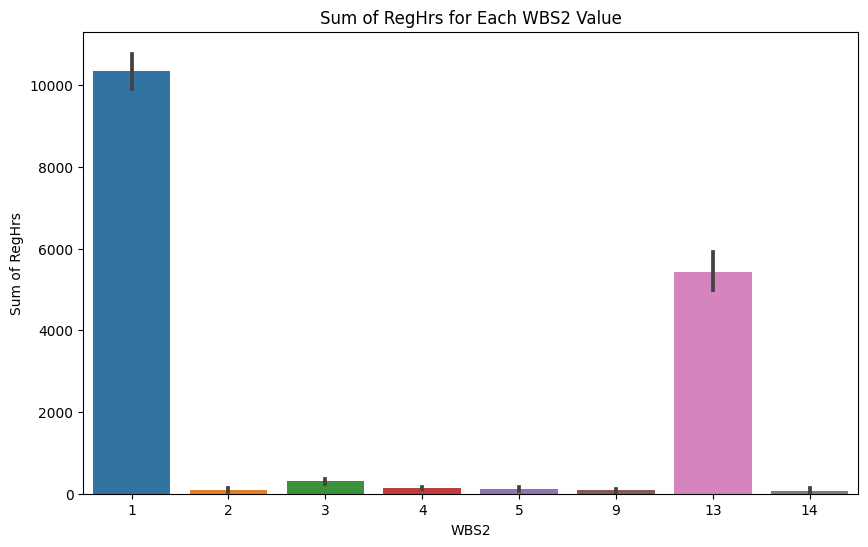

In [131]:
# filter to only the active project
filtered_df = df_LD[df_LD['WBS1'] == active_project]

# Plot a bar chart of the sum of 'RegHrs' for each unique value in the "WBS2" column
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_df,
            x='WBS2',
            y='RegHrs',
            estimator=sum,
            order=filtered_df['WBS2'].value_counts().sort_index().index)
plt.title('Sum of RegHrs for Each WBS2 Value')
plt.xlabel('WBS2')
plt.ylabel('Sum of RegHrs')
plt.show()

<Figure size 800x3200 with 0 Axes>

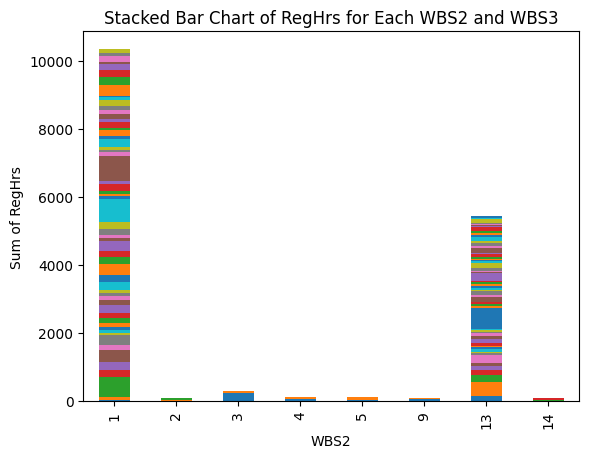

In [132]:
plt.figure(figsize=(8, 32))
# filter to only the active project
filtered_df = df_LD[df_LD['WBS1'] == active_project]

# Create a pivot table to get the sum of 'RegHrs' for each unique combination of WBS2 and WBS3
pivot_table = filtered_df.pivot_table(values='RegHrs',
                                      index='WBS2',
                                      columns='WBS3',
                                      aggfunc=sum,
                                      fill_value=0)

# Plot as a stacked bar chart
ax = pivot_table.plot(kind='bar', stacked=True, legend=False)
plt.title('Stacked Bar Chart of RegHrs for Each WBS2 and WBS3')
plt.xlabel('WBS2')
plt.ylabel('Sum of RegHrs')
plt.show()

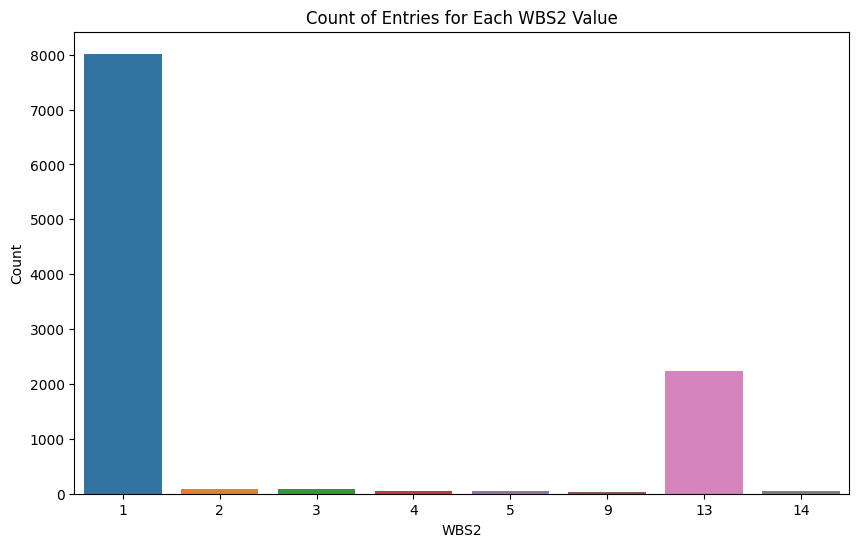

In [133]:
# filter to only the active project
filtered_df = df_LD[df_LD['WBS1'] == active_project]

# Plot a bar chart of counts for each unique value in the "WBS2" column
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, x='WBS2', order=filtered_df['WBS2'].value_counts().sort_index().index)
plt.title('Count of Entries for Each WBS2 Value')
plt.xlabel('WBS2')
plt.ylabel('Count')
plt.show()

Let's try to establish 'acquired' dates, and which clients are and are not acquired.

In [134]:
df = df_PR.merge(df_CL[['ClientID', 'ClientCreated']], how='left', on='ClientID')

In [135]:
df.head()

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend,ClientCreated
0,P01.1997.00983T,PROP,PROPOSA,2002-11-04,PWCPS,Proposal,2002-11-01,0.0,Springwoods Elementary School,Proposal,Prince William County Public Schools,None,None,2006-07-28 00:00:00
1,P01.1998.001303,PROP,PROPOSA,2002-02-09,CFM MGMT,Proposal,2000-09-29,0.0,4816 - 4826 Chevy Chase Drive,Proposal,"CFM Management Services, Inc.",None,None,2006-07-28 00:00:00
2,P01.1998.001504,PROP,PROPOSA,2001-10-15,BETHESDAPK,Proposal,2001-10-15,0.0,Bethesda Park Condominium,Proposal,Bethesda Park Condominium,None,None,2006-07-28 00:00:00
3,P01.1999.001692,PROP,CONS/RE,2003-04-21,EARTHTECH,Consultation & Report,2003-04-21,0.0,Route 28/ Wellington Rd/ NS Railroad,Consultation & Report,"Earth Tech, Inc.",None,None,2006-07-28 00:00:00
4,P01.1999.001874,PROP,PROPOSA,2002-03-27,MCKISSACK,Proposal,2002-03-27,0.0,McKissack DC OPM Support,Proposal,McKissack & McKissack,None,None,2006-07-28 00:00:00


In [136]:
df['ClientID'].value_counts()

FEA                                 7514
C89DCC56D3B043ED926B07B57CE7C924    2248
NPS                                 1273
JLL                                 1099
GENERALSRV                           587
                                    ... 
MKOLESAR1198177011624                  1
MKOLESAR1199378423546                  1
NFISCHER1202161900161                  1
JYOUNG1210264018892                    1
MTOOMEY1249992232765                   1
Name: ClientID, Length: 3968, dtype: int64

In [191]:
# get the column ready for acquisition dates
df_CL['DateAcquired'] = None

In [192]:
client_list = df['ClientID'].unique()

In [193]:
for client in client_list:
    CL_row = df_CL[df_CL['ClientID'] == client]
    PR_slice = df[df['ClientID'] == client]
    client_projects = PR_slice['WBS1'].value_counts().index
    
    R_codes = [project for project in client_projects if "R" in project]
    P_codes = [project for project in client_projects if "P" in project]
    
    result_dict = {}
    for code in R_codes:
        # Filter DataFrame for the current R_code
        one_project = df[df['WBS1'] == code]

        # Find the minimum StartDate for the current group
        min_start_date = one_project['StartDate'].min()

        # Store the result in the dictionary
        result_dict[code] = min_start_date
        
    # Get the earliest R code date.
    if not result_dict:
        pass
    else:
        acquire_date = min(result_dict.items(), key=lambda x: x[1])
        # rest of your code

    # set that value in df_CL as DateAcquired
    df_CL['DateAcquired'][df_CL['ClientID'] == client] = acquire_date[1]    

The above should represent the earliest R code project start date for a given client.

Based on this we can calculate an overall percentage of clients we eventually "get", or do not get.

In [194]:
# df_CL.head()
# some clients are not acquired, therefore DateAcquired remains null
no_clients = len(df_CL)
no_got = len(df_CL[df_CL['DateAcquired'].notnull()])
no_ungot = len(df_CL[df_CL['DateAcquired'].isna()])
pct_got = no_got / no_clients * 100
pct_ungot = no_ungot / no_clients * 100
print(f"{no_got} total -- {pct_got}% of all {no_clients} clients eventually acquired\n\
{no_ungot} total -- {pct_ungot}% of all {no_clients} clients not acquired.")

3629 total -- 59.50155763239875% of all 6099 clients eventually acquired
2470 total -- 40.49844236760124% of all 6099 clients not acquired.


In [195]:
# now to find which P#s were pre-acquisition for "got" clients
got_clients = df_CL[df_CL['DateAcquired'].notnull()]
got_client_list = got_clients['ClientID'].unique()

In [319]:
client = got_clients.iloc[1]['ClientID']
CL_row = df_CL[df_CL['ClientID'] == client]
PR_slice = df[df['ClientID'] == client]
client_projects = PR_slice['WBS1'].value_counts().index

R_codes = [project for project in client_projects if "R" in project]
P_codes = [project for project in client_projects if "P" in project]

# start_dates = []
selected_project_codes = []
for code in P_codes:
    # Filter DataFrame for the current P_code
    P_slice = df[df['WBS1'] == code]
    if len(P_slice) < 1:
        print("Length 0 or less. Something went very wrong.")
    elif len(P_slice) > 1:
        print(f"Length 2 or greater. See below:\n{P_slice}")
    else:
        start_date = P_slice.iloc[0]['StartDate']
        if start_date < get_date:
            selected_project_codes.append(code)

print("Pre-Acquisition Project Codes:", selected_project_codes)

# get_date = df_CL['DateAcquired'][df_CL['ClientID'] == client].iloc[0]
# acquisition_props = [date for date in start_dates if date < get_date]
# acquisition_props
    
#     min_start_date = P_slice_dates.min()
#     start_dates.append(min_start_date)
# start_dates

Pre-Acquisition Project Codes: ['P01.2008.005703']


In [320]:
df_CL['AcquistionProjects'] = None

In [322]:
df_CL['AcquistionProjects'][df_CL['ClientID'] == client] = selected_project_codes

In [323]:
df_CL[df_CL['ClientID'] == client]

,ClientID,ClientName,SpecialtyType,Recommend,ClientCreated,DateAcquired,AcquistionProjects
2,MPORTALATIN1209569252051,100 Church Street Condominium Association,NaN,N,2008-04-30 15:32:18,2012-10-08 00:00:00,P01.2008.005703


In [ ]:
# excellent! Now I just need to apply this same code recursively

In [289]:
df[df['WBS1'] == 'P01.2008.005703']

,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend,ClientCreated
35129,P01.2008.005703,PROP,PROP,2008-05-20,MPORTALATIN1209569252051,Proposal,NaT,0.0,100 Church Street Condominium Reserve Study,Proposal,100 Church Street Condominium Association,None,None,2008-04-30 15:32:18


In [215]:
start_dates = []
for code in P_codes:
    start_dates.append(df['StartDate'][df['WBS1'] == code])


        one_project = df[df['WBS1'] == code]

        # Find the minimum StartDate for the current group
        min_start_date = one_project['StartDate'].min()

        # Store the result in the dictionary
        result_dict[code] = min_start_date
        
    # Get the earliest R code date.
    if not result_dict:
        pass
    else:
        acquire_date = min(result_dict.items(), key=lambda x: x[1])
    
    
start_dates

[9052   2013-01-07
 Name: StartDate, dtype: datetime64[ns],
 35129   2008-05-20
 Name: StartDate, dtype: datetime64[ns]]

In [184]:
project_code = P_codes[0]
start_dates = df['StartDate'][df['WBS1'] == project_code]


,WBS1,WBS2,WBS3,StartDate,ClientID,Name,ContractDate,TotalProjectCost,ProjectName,PhaseName,ClientName,SpecialtyType,Recommend,ClientCreated
36566,P05.2013.000872,PROP,PROP,2013-09-02,0C8D295068DC4798AE9F7B2A3BE12ADF,Proposal,NaT,0.0,8151 Southpark Lane Due Diligence,Proposal,475,None,None,2013-08-27 20:14:06


In [174]:
got_clients = df_CL[df_CL['DateAcquired'].notnull()]
got_client_list = got_clients['ClientID'].unique()

for client in got_client_list:
    CL_row = df_CL[df_CL['ClientID'] == client]
    PR_slice = df[df['ClientID'] == client]
    client_projects = PR_slice['WBS1'].value_counts().index
    
    R_codes = [project for project in client_projects if "R" in project]
    P_codes = [project for project in client_projects if "P" in project]
    

(3630, 6)

Get P#s ONLY that are before the the first R# date.
R# will be directly copied from 

The problem: the way a project is set up is not always the same.  Some will only have 1 prop, 1 proj per acquired project.  NPS for example though will be as above , but will also have more than 1 of each (different projects as Phases)

Can use LD TransDate - remember it's about 3 weeks after labor was recorded.

R# min date should be exactly when we've executed contract.  This will ultimately be fuzzy in the range of 1 month, but that's fine.

Counting all P# labor before contract as acquisition labor, plus applicable OHD labor, we get CAC. (At least cost in hours)

Ballpark: <u>$75.24/hr</u> for anyone (avg)

Write something that includes calculating with rate but hand it over to Ryan for rate

NOTE: the "contract date" is the same for both the proposal and the project itself. The "createdDate" will show the different dates for proposal versus project when filtering WBS2 = blank

In [7]:
df_LD['TransDate'].head()

NameError: name 'df_LD' is not defined

In [ ]:
[df['ProjectName'] for x in 

In [ ]:
df_PR.head()

In [ ]:
PWCPS_projects = df_PR[df_PR['ClientID'] == 'PWCPS']["WBS1"].value_counts()

In [ ]:
PWCPS_projects.index

In [ ]:
# WBS1 and project names are not matching up at all
for project in PWCPS_projects.index:
    print(df_PR[df_PR['WBS1'] == project]['ProjectName'])

In [ ]:
# Slice the DataFrame where WBS2 is equal to 13
subset = filtered_df[filtered_df['WBS2'] == 13]

# Plot a bar chart of counts for each unique value in the "WBS3" column within the subset
plt.figure(figsize=(10, 6))
sns.countplot(data=subset, x='WBS3', order=subset['WBS3'].value_counts().index)
plt.title('Count of Entries for Each WBS3 Value (WBS2 = 13)')
plt.xlabel('WBS3')
plt.ylabel('Count')
plt.show()

Okay, that's strange too, why is there only 1 instance of each?

In [8]:
# checking this in the original
df_LD[df_LD['WBS1'] == 'R05.2015.986001']['WBS2'].value_counts()

NameError: name 'df_LD' is not defined

In [ ]:
temp_LD = df_LD[df_LD['WBS1'] == 'R05.2015.986001']
temp_LD[temp_LD['WBS2'] == 1]['WBS3'].value_counts().head()

In [ ]:
NPS_test[NPS_test['WBS2'] == 13]
# ask about where I can cross-reference phase and task numbers so they mean something

In [ ]:
NPS_test['WBS3'].value_counts()

In [ ]:
df_PR['ProjectName'].value_counts()

In [ ]:
NPS_test['ProjectName'].value_counts()[0:20]

In [ ]:
# looking at LD now
df_LD.head()

In [ ]:
# make pd.series of all P## project codes, R## project codes, and OHD codes in LD

ohd_codes = df_LD[df_LD['WBS1'].str.startswith('OHD')]['WBS1'].value_counts()
# 372095 OHD codes
r_codes = df_LD[df_LD['WBS1'].str.startswith('R')]['WBS1'].value_counts()
# 696996 R codes
p_codes = df_LD[df_LD['WBS1'].str.startswith('P')]['WBS1'].value_counts()
# 272768 P codes

In [ ]:
r_codes

In [ ]:
df_LD.head()

In [9]:
df_LD['WBS2'].value_counts()

NameError: name 'df_LD' is not defined

In [ ]:
# add one row for each WBS1 in df_PR to new df, with the same client info.

# suppress annoying warning message spam
pd.options.mode.chained_assignment = None  # default='warn'

# empty list to store rows for the new dataframe
new_rows = []

# Iterate through unique common ClientIDs
for client_id in clientID_list:
    # Get associated WBS1 values from df_PR
    project_wbs1 = df_PR[df_PR['ClientID'] == client_id]['WBS1'].tolist()
    active_row = df.loc[df['ClientID'] == client_id]
    i = 0
    # iterate through all assoc. values of wbs1
    while i < len(project_wbs1):
        if i == 0:
            df.loc[df['ClientID'] == client_id, 'WBS1'] = project_wbs1[i]
            # nested for loop for WBS2 and WBS3
            for wbs2, wbs3 in zip(df_PR[(df_PR['WBS1'] == project_wbs1[i])]['WBS2'], 
                                  df_PR[(df_PR['WBS1'] == project_wbs1[i])]['WBS3']):
                new_row = active_row.copy()
                new_row['WBS1'] = project_wbs1[i]
                new_row['PhaseTask'] = f"{wbs2}-{wbs3}"
                df = pd.concat([df, new_row], ignore_index=True)
            i += 1
        elif i < len(project_wbs1):
            # Create a single new row
            new_row = active_row.copy()
            # Set the new 'WBS1' value
            new_row.loc[new_row.index[0], 'WBS1'] = project_wbs1[i]
            # nested for loop for WBS2 and WBS3
            for wbs2, wbs3 in zip(df_PR[(df_PR['WBS1'] == project_wbs1[i])]['WBS2'], 
                                  df_PR[(df_PR['WBS1'] == project_wbs1[i])]['WBS3']):
                new_row = active_row.copy()
                new_row['WBS1'] = project_wbs1[i]
                df = pd.concat([df, new_row], ignore_index=True)
            i += 1
        else:
            print(f"Client {client_id} has {i} associated projects.")
            # reset i
            i = 0
        
        # reset i
        i = 0

In [ ]:
# attempt to slim down biggest pkls - LD then all Ledgers

In [ ]:
df_LD.shape

In [ ]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    # use with+display to temporarily change the max_rows
    display(df_LD.isna().sum())

In [ ]:
df_LD['CreditLedgerMiscPKey'].sample(12)

In [ ]:
df.to_pkl
### LEFT OFF HERE
# add in other columns, such as project cost #check with Angie whether this is accurate/usable
# then start the process of merging in LD
# with that done, start trying to pull metrics out of it
# loop back as needed to add features

## assigned PhaseTask column before the clientID loop, but it's still taking a year and a day

In [ ]:
df_PR.head()

In [ ]:
# what to do about the nulls and mismatches
df_PR.loc[df_PR['ClientID'].isnull()]

### Projects Per Client


### Customer Acquisition Cost (CAC)
1. Determine when client was 'acquired'
2. Determine labor that went into them prior to that
3. Determine how much labor is put into non-acquired clients
4. Follow-on Work: P-numbers created after st R# created

##### Resource Toll:
How much it costs us in hours (resource toll) / rates?  Add in overhead hours distributed (BDEV) according to rule we came up with
##### Revenue:
Compare Revenue to Resource Toll to get ROI / CAC table, then look for other relationships
For BDEV: look for all WBS1 with 'BDEV', then associate that with employees, then we find what projects a given employees worked on.  Find all R#s and their WBS3 codes that employee worked on.  Every R# should connect to a single P#, and we associate the BDEV time there.

In [10]:
df_LD['WBS2']

NameError: name 'df_LD' is not defined

In [ ]:
# Get employee by project number.
# start with an R number for testing
r_number = "R05.2020.001260"
filtered_labor = df_LD[df_LD['WBS1'] == r_number]
# drill down to WBS3
# first, create a combined column of WBS codes
filtered_labor['WBS2+3'] = f"Phase: {filtered_labor['WBS2']} Task: {filtered_labor['WBS3']}"
wbs3_unique = filtered_labor['WBS3'].unique()

In [ ]:
filtered_labor['WBS2'].value_counts()

In [ ]:
filtered_labor['WBS3'].value_counts()

#### Labor, by client, Project, and Type

In [11]:
# this function (WIP, PROP version still needs fixing) totals labor hours by client
# it matches all WBS1 codes associated with the ClientID in the PR table
# then finds all entries in LD associated with that WBS1
# it can also take parameters to only find hours marked "N" for NonBill,
# and (will) match only WBS2 = PROP hours 
# (I think this last needs to do some more cross-table magic to work properly)
def get_labor_by_client(filter_value, df_PR, df_LD, mode='default'):
    # Filter rows where 'ClientID' matches the filter value
    filtered_df = df_PR[df_PR['ClientID'].isin([filter_value])]

    # Get unique values from the 'WBS1' column in the filtered DataFrame
    unique_values = filtered_df['WBS1'].unique()

    # Convert the unique values to a list
    unique_values_list = list(unique_values)

    # Initialize dictionaries to store totals
    reg_hours = {}
    ovt_hours = {}
    prop_reg_hrs = {}
    prop_ovt_hrs = {}
    billable_reg_hrs = {}
    billable_ovt_hrs = {}
    
    # Initialize total variables
    reg_hrs_total = 0
    ovt_hrs_total = 0
    prop_reg_hrs_total = 0
    prop_ovt_hrs_total = 0
    billable_reg_hrs_total = 0
    billable_ovt_hrs_total = 0
    
    # initialize df_LD_filtered in the correct scope
    df_LD_filtered = df_LD

   # Filters for 'proposal' and 'billable' modes
    prop_df_LD_filtered = df_LD[df_LD['WBS2'].astype(str).str.startswith('PROP')]
    # PROP might not capture all.  All P numbers down to level 3
    # P & R # filters
    
    billable_df_LD_filtered = df_LD[df_LD['NonBill'].isin([None, 'N'])]
    # get total revenue billed broken down by task instead
    
    # Initialize lists to store result strings
    result_strings = []
    prop_result_strings = []
    billable_result_strings = []
    
    # Iterate over unique values and calculate totals
    for wbs1_code in unique_values_list:
        relevant_rows = df_LD_filtered[df_LD_filtered['WBS1'] == wbs1_code]
        reg_hours_current = relevant_rows['RegHrs'].sum()
        ovt_hours_current = relevant_rows['OvtHrs'].sum()
        
        # Update total variables
        reg_hrs_total += reg_hours_current
        ovt_hrs_total += ovt_hours_current
        
        result_string = f"WBS1 Code: {wbs1_code}, Regular Hours: {reg_hours_current}, Overtime Hours: {ovt_hours_current}"
        result_strings.append(result_string)
        
        # Check if it matches 'PROP' criteria
        if wbs1_code in prop_df_LD_filtered['WBS1'].unique():
            prop_result_strings.append(result_string)
            
            # Update total variables
            prop_reg_hrs_total += reg_hours_current
            prop_ovt_hrs_total += ovt_hours_current

        # Check if it matches 'billable' criteria
        if wbs1_code in billable_df_LD_filtered['WBS1'].unique():
            # Exclude 'PROP' hours from billable total
            if wbs1_code not in prop_df_LD_filtered['WBS1'].unique():
                billable_result_strings.append(result_string)
            
                # Update total variables
                billable_reg_hrs_total += reg_hours_current
                billable_ovt_hrs_total += ovt_hours_current

    # Determine which results to return
    if mode == 'total':
        result_strings.append(f"Totals for {filter_value}: {reg_hrs_total} regular hours and {ovt_hrs_total} overtime hours.")
    elif mode == 'proposal':
        result_strings.append(f"Proposals for {filter_value}: {prop_reg_hrs_total} regular hours and {prop_ovt_hrs_total} overtime hours.")
    elif mode == 'billable':
        result_strings.append(f"Billable Hours for {filter_value}: {billable_reg_hrs_total} {billable_ovt_hrs_total}")
    else:
        result_strings.append(f"Totals for {filter_value}: {reg_hrs_total} regular hours and {ovt_hrs_total} overtime hours.")
        result_strings.append(f"Proposals for {filter_value}: {prop_reg_hrs_total} regular hours and {prop_ovt_hrs_total} overtime hours.")
        result_strings.append(f"Billable Hours for {filter_value}: {billable_reg_hrs_total} regular hours and {billable_ovt_hrs_total} overtime hours.")

    return result_strings

In [12]:
df_LD['RegAmt']

NameError: name 'df_LD' is not defined

In [ ]:
# # Example usage
# total_result_strings, prop_result_strings, billable_result_strings = get_labor_by_client('NPS', df_PR, df_LD)
total_result_strings = get_labor_by_client('NPS', df_PR, df_LD, mode='default')

In [ ]:
# # Print total result strings
print("Total Result Strings:")
for result_string in total_result_strings:
    print(result_string)

# # Print prop result strings
# print("\nProposal Result Strings:")
# for result_string in prop_result_strings:
#     print(result_string)

# # Print billable result strings
# print("\nBillable Result Strings:")
# for result_string in billable_result_strings:
#     print(result_string)

#### Which clients are "acquired" and when?

In [13]:
df_PR.head()

NameError: name 'df_PR' is not defined

In [ ]:
filtered_df = df_PR.loc[(df_PR['ClientID'] == 'NPS') & (df_PR['WBS1'].str.startswith('R'))]
sorted_dates = filtered_df['CreateDate'].sort_values()

In [ ]:
sorted_dates

In [ ]:
df_PR.loc[df_PR['WBS1'] == 'R05.2020.001260', 'TotalProjectCost'].value_counts()

#### Labor and Rates; Overhead & Proposals, by Employee

#### Other EDA topics

In [14]:
#  SAMPLE CODE - make sure none are repeated in a list
# TEMP_clientIDcounts = df_CL['ClientID'].value_counts()
# TEMP_clientIDcounts[TEMP_clientIDcounts > 1]

### Customer Acquisition, Part 1
- Establish which clients are "acquired" and which are not, by categorizing based on whether they have at least one R number associated
- Establish when each client was "acquired" by finding the first R number created for them.

In [15]:
# since NPS is a major client we'll use those for the test example
NPS_projects = df_PR[df_PR['ClientID'].isin(["NPS"])]

NameError: name 'df_PR' is not defined

In [ ]:
all_clients = df_CL['Name'].unique()
print(len(all_clients))
all_clients[9]

In [ ]:
try:
    all_clients = df_CL['Name'].unique()
    all_client_ids = df_CL['ClientID'].unique()
    
    if len(all_clients) != len(all_client_ids):
        raise Exception("Mismatched number of unique values in 'Name' and 'ClientID'.")
    
    # Create a smaller dataframe with ClientID and Client columns
    clients = pd.DataFrame({'ClientID': all_client_ids, 'Name': all_clients})
    
    # Print the 10th entry as a sample
    print(clients.iloc[9])
except Exception as e:
    print(f"Error: {e}")

In [ ]:
# getting different lengths for client names and IDs
len(all_clients)

In [ ]:
# find and return client IDs when there are more than 1 associated with a given Name

# Initialize the list of tuples
name_ID_pairs = []

# Iterate over unique names and create tuples
for name in all_clients:
    client_ids = df_CL.loc[df_CL['Name'] == name, 'ClientID'].unique()
    if len(client_ids) > 1:
        name_ID_pairs.append((name, client_ids.tolist()))

# Print tuples where list length is greater than 1
for pair in name_ID_pairs:
    if len(pair[1]) > 1:
        print(pair)

In [ ]:
## For now I'm ignoring Client and ClientID.  There's some weirdness there I'd like to
# get to the bottom of but it probably won't affect my CAC calculation

# df_CL['Client'].value_counts().sort_values()
# df_CL.loc[df_CL['Client'] == "ASID"]
# df_CL.head()

In [ ]:
# using NPS as a test case as they are a major client
NPS_proposal_count = len([code for code in NPS_projects['WBS2'] if str(code)[0:4] == 'PROP'])
NPS_proposal_hrs = len([code for code in NPS_projects['WBS2'] if str(code)[0:4] == 'PROP'])
NPS_billable_hrs = len([code for code in NPS_projects['WBS2'] if str(code)[0:4] == 'PROP'])

In [ ]:
# currently just the number of entries, need to add in hours
NPS_proposal_ratio = len(NPS_projects) / NPS_proposal_count
print(f"{NPS_proposal_count} labor hours on proposals out of {len(NPS_projects)} total project hours.\n\
Ratio of ~{round(NPS_proposal_ratio, 2)} billable hours for every hour spent on proposals.")

In [ ]:
NPS_proposal_count

In [ ]:
NPS_projects.head()

In [ ]:
# Filter for rows where 'WBS2' contains "PROP"
NPS_proposals = NPS_projects[NPS_projects['WBS2'].astype(str).str.startswith("PROP")]

# Get the length of the resulting DataFrame
len(NPS_proposals)

In [16]:
NPS_proposals['WBS1'].value_counts()

NameError: name 'NPS_proposals' is not defined

In [ ]:
df_LD.loc[df_LD['WBS1'] == "P05.2015.000986"]

In [ ]:
print(f"Labor Details contains {len(df_LD)} entries constituting {df_LD['RegHrs'].sum().round()} \
total hours. \n\
On average each entry represents {df_LD['RegHrs'].mean()} hours labor, and the \
median entry is {df_LD['RegHrs'].median()} hours. \n\
")

### Key Derived Metrics
1. Customer Acquisition Cost
    1. Basically, compare the proportion of customer acquisition activities to 1 actual client
    2. match CL: ClientID to Opportunity: ClientID & PR: ClientID
    3. Match client to project to get WBS1 code, match that to labor on LD: WBS1 & AR: WBS1
    4. find labor codes for customer acquisition activities (WBS2/3)
    5. Compare that to AR values for projects associated with that customer
2. Customer Lifetime Value
    1. First, need to find customer lifetime.  All Projects assoc. with customer & billing assoc. with that project. Total the AR.
    2. Factor in CAC -- vs # billable hours for client 
    3. Avg value (per year lifetime)
    4. Should select only customers we haven't done work for in the past (some number) years as examples to determine an actual "lifetime". Some may be ongoing - factor that in estimating an average "lifetime" but not in lifetime values.  Assume active customers will last at least the median number years and forecast value on that -- also adjust the average lifetime upwards based on those who are ongoing for longer than the previous mean.    
3. Average Revenue Per Client
    1. find CLV, then average
4. Customer contract lifetime
    1. See above, find avg. lifetime.
5. Overall Conversion Rate
    1. relies on identifying job codes associated with customer acquisition, per CAC (1C)
    2. Compare Opportunities to actual billed projects, by Client.
    3. DO include clients with 0 billable hours, that's key here
6. Retention/Churn Rate
    1. Look at size of gaps between contracts to determine when a customer is "inactive"
    2. How many acquisition activity hours spent per 1 actual client -- and how many billable hours per actual client, avg.
7. Characterize Sales Funnel - time and cost at various stages
    1. This is where we break down the actual activities more and assign hours (range, median, mean) to each stage.  Hours then turn to dollars.
8. Efficiency Metrics, cost to do X, fulfillment times, resource utilization
    1. can follow from above
9. Forecasting
    1. follow from above
10. Customer Segmentation

### How to Get There
1. Top level stuff:
    - Characterizing sales funnel must be one of the first things
        - graph hours spent on different activities (WBS2?) regardless of project.  
            - particular attention to Opportunities.  PRProposalWBS1 vs. PRWBS1
            - connect to LD to determine labor hours and labor costs of same ^
        - Identify WBS codes that are specific to (or at least far more common on) Proposal WBS codes than Opportunity WBS codes
    - Avg. value of new client
        - Summed value (billable hours and amounts) of a Project
        - summed value all projects of a given client
        - date range of those projects as divisor - value of client per month of client lifetime
        - client lifetimes
    - test
        - test
    - test
    
2.  